<a href="https://colab.research.google.com/github/volpesofi/Surfaceome/blob/main/ArchS4_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GEO Bladder Cancer

*   **input**: the ID of the GEO series you want to interrogate and a metadata
*   **output**: A list of surface protein differential expressed in cancer and normal samples.


In [1]:
# just for the first time install all the missing R packages
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
# packages
packages <- c("data.table", "ggplot2", "openxlsx", "enrichR", "VennDiagram", 
"venn", "assertr", "remotes", "ggrepel", "viridis", "pals",  "wesanderson",
"cowplot", "ggpubr", "gridExtra", "grid", "patchwork", "pheatmap")
Biocond_packages <- c("edgeR", "DESeq2", "rhdf5", "magick")
# install
install.packages(setdiff(packages, rownames(installed.packages()))) 
BiocManager::install(setdiff(Biocond_packages, rownames(installed.packages())))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘formatR’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘lambda.r’, ‘futile.options’, ‘corrplot’, ‘car’, ‘rjson’, ‘futile.logger’, ‘admisc’, ‘dichromat’, ‘mapproj’, ‘maps’, ‘ggsci’, ‘ggsignif’, ‘polynom’, ‘rstatix’


Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'edgeR', 'DESeq2', 'rhdf5', 'magick'

also installing the dependencies ‘bit’, ‘bitops’, ‘bit64’, ‘plogr’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘RSQLite’, ‘XML’, ‘xtable’, ‘GenomeInfoDb’, ‘XVector’, ‘MatrixGenerics’, ‘DelayedArray’, ‘snow’, ‘AnnotationDbi’, ‘annotate’, ‘limma’, ‘locfit’, ‘S4Vectors’, ‘IRanges’, ‘G

In [2]:
# load libraries 
suppressMessages(library("rhdf5"))
suppressMessages(library("edgeR"))
suppressMessages(library("DESeq2"))
suppressMessages(library("enrichR"))
suppressMessages(library('VennDiagram'))
suppressMessages(library(venn))
suppressMessages(library(data.table))
suppressMessages(library(openxlsx))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(stringr))
suppressMessages(library(assertr))
suppressMessages(library("remotes"))

suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(ggrepel))
suppressMessages(library("RColorBrewer"))
suppressMessages(library("viridis"))
suppressMessages(library('pals'))
suppressMessages(library(wesanderson))
suppressMessages(library(cowplot))
suppressMessages(library(ggpubr))
suppressMessages(library(grid))
suppressMessages(library(gridExtra))
suppressMessages(library(patchwork))
#suppressMessages(library("magick"))

#library(org.Hs.eg.db)
#library("biomaRt")


To identify proteins on the surface we use SURFY (from [*The in silico human surfaceome*;  
Proc Natl Acad Sci U S A.; 2018;115(46):E10988-E10997.](https://wlab.ethz.ch/surfaceome/))

In [7]:
#URL = 'https://raw.githubusercontent.com/auroramaurizio/My_csv/master/500_drugsComTrain_raw_copy1.csv'
#download.file(URL, destfile = './500_drugsComTrain_raw_copy1.csv')
#head(read.csv(url(URL)))

,uniqueID,drugName,condition,review,rating,date,usefulCount
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>
1,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9,20-May-12,27
2,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. We have tried many different medications and so far this is the most effective.""",8,27-Apr-10,192
3,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge. The positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",5,14-Dec-09,17
4,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",8,3-Nov-15,10
5,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.""",9,27-Nov-16,37
6,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp; hurt! Leg/ankles aches severe lower bowel preassure like you need to go #2 but can&#039;t! Enjoyed the initial rockhard erections but not at these side effects or $230 for months supply! I&#039;m 50 &amp; work out 3Xs a week. Not worth side effects!""",2,28-Nov-15,43


In [16]:
# download surfy table
surfaceome_table_url='https://wlab.ethz.ch/surfaceome/table_S3_surfaceome.xlsx'

ST = rio::import(file = surfaceome_table_url, which = 1, readxl = FALSE, startRow = 2) 
ST = ST[!is.na(ST$UniProt.name),]
ST = ST[!is.na(ST$GeneID),]
row.names(ST) <- ST$UniProt.name



# MERGE GEO

In [ ]:
# unfrotunantly this don't work
# at the moment I have uploaded directly the file into the file section
# can't use drive either due to R kernel
metadata_url='https://www.dropbox.com/s/rimewtprqbyz779/GEO_bladder_ArchS4_all2.xlsx'
download.file(metadata_url, destfile = './GEO_bladder_ArchS4_all.xlsx')
list.files()

[1] "GEO_bladder_ArchS4_all.xlsx"  "GEO_bladder_ArchS4_all2.xlsx"
[3] "sample_data"                  "table_S3_surfaceome.xlsx"

In [ ]:
metadata_ArchS4 = read.xlsx('GEO_bladder_ArchS4_all2.xlsx')
samp = metadata_ArchS4$samples
length(samp)
table(metadata_ArchS4$condition)
table(metadata_ArchS4$series)

[1] 153


  N   T 
 45 108 


GSE111320 GSE120795 GSE133624  GSE16256  GSE59483  GSE77661  GSE78529  GSE78530 
        1         5        65         1        59         2         2         2 
 GSE78563  GSE81201  GSE97239 
        2         8         6 

Download matrix with the GEO counts (saved in expression) for the GSE selected series (in variable sample_location) 

In [ ]:
set.seed(42)
options(timeout=600) # increase timeout due to file size

# download file from:
# https://mssm-seq-matrix.s3.amazonaws.com/human_matrix.h5
matrixh5_url='https://mssm-seq-matrix.s3.amazonaws.com/human_matrix.h5'
download.file(matrixh5_url, destfile = './human_matrix.h5')

input = "human_matrix.h5"
res = h5ls(input)

series = h5read(input, "meta/Sample_series_id")
samples = h5read(input, "meta/Sample_geo_accession")
genes = h5read(input, "meta/genes")

sample_locations = which(samples %in% samp)

# extract gene expression from compressed data
expression = h5read(input, "data/expression", index=list(1:length(genes), sample_locations))
H5close()
rownames(expression) = genes
colnames(expression) = samples[sample_locations]

# Print file
head(expression)
write.table(expression, file="./GEObladder_expression.tsv", sep="\t", quote=FALSE)


,GSM2055791,GSM2055798,GSM2144557,GSM2144558,GSM2144559,GSM2144547,GSM2144545,GSM2144548,GSM2144546,GSM2144560,⋯,GSM3913453,GSM3913454,GSM3913455,GSM3913456,GSM3913457,GSM3913458,GSM3913459,GSM3913460,GSM3913461,GSM3913462
A1BG,107,41,42,99,58,66,47,27,80,34,⋯,270,71,130,96,209,191,79,121,359,89
A1CF,21,15,2,5,0,0,4,1,10,2,⋯,60,70,21,15,32,55,10,21,26,9
A2M,42680,4436,2339,2951,308,304,2377,768,3011,746,⋯,3641,2693,1565,2702,8764,4473,1274,7824,56712,5816
A2ML1,37,343,28,36,13,9,30,9,27,13,⋯,221,1252,207,58,451,48,800,259,99,24
A2MP1,29,6,6,2,0,0,8,38,3,40,⋯,24,18,16,50,64,25,14,28,167,15
A3GALT2,2,3,0,1,0,0,0,11,2,8,⋯,2,0,4,2,2,3,0,3,0,2


In [ ]:
setdiff(metadata_ArchS4$samples,colnames(expression)) # check for missing samples
row.names(metadata_ArchS4) = metadata_ArchS4$samples
fCountsData = expression
fCountsData <- fCountsData[,match(metadata_ArchS4[,1], colnames(fCountsData))] 

character(0)

Perform DGE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


keep
FALSE  TRUE 
16888 18350 

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

30 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



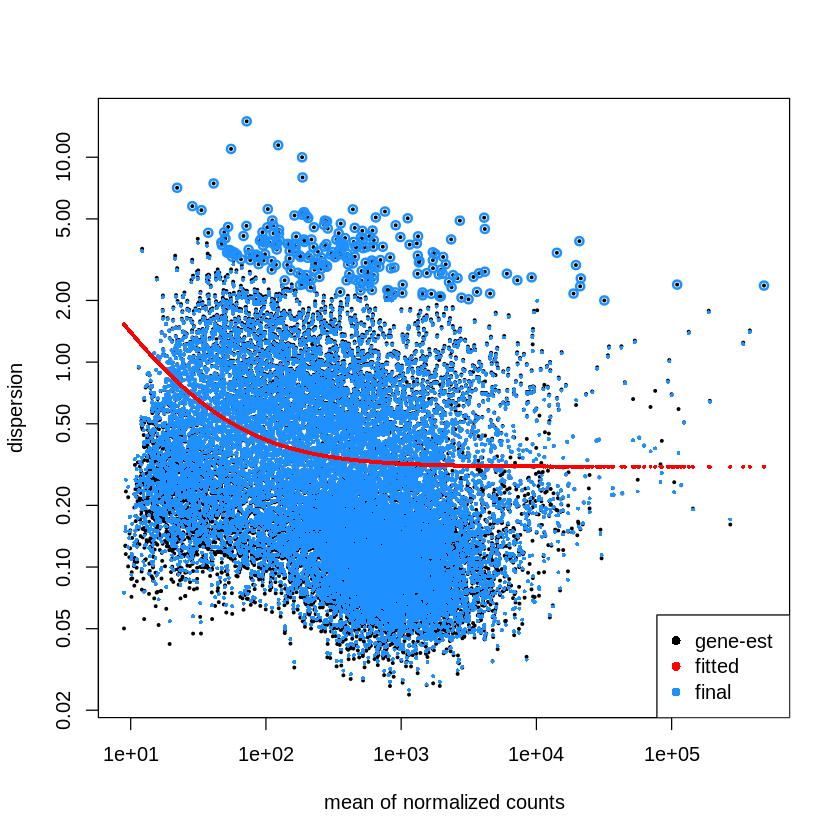

In [ ]:
# perform DGE
design.formula = as.formula("~condition+series")
dds <- DESeqDataSetFromMatrix(countData = fCountsData,
                              colData = metadata_ArchS4,
                              design = design.formula)


# FILTER FOR GENE EXPRESSION 
min.samples = 45
keep <- rowSums(cpm(counts(dds)) >= 1) >= min.samples
table(keep)
dds <- dds[keep,]

cpm = cpm(counts(dds), log = F)

#DGE
dga <- DESeq(object = dds, 
             test = "Wald", 
             fitType = "parametric", 
             betaPrior = FALSE,
             minReplicatesForReplace = Inf)
#Dispersion plot
plotDispEsts(dga)

png 
  2

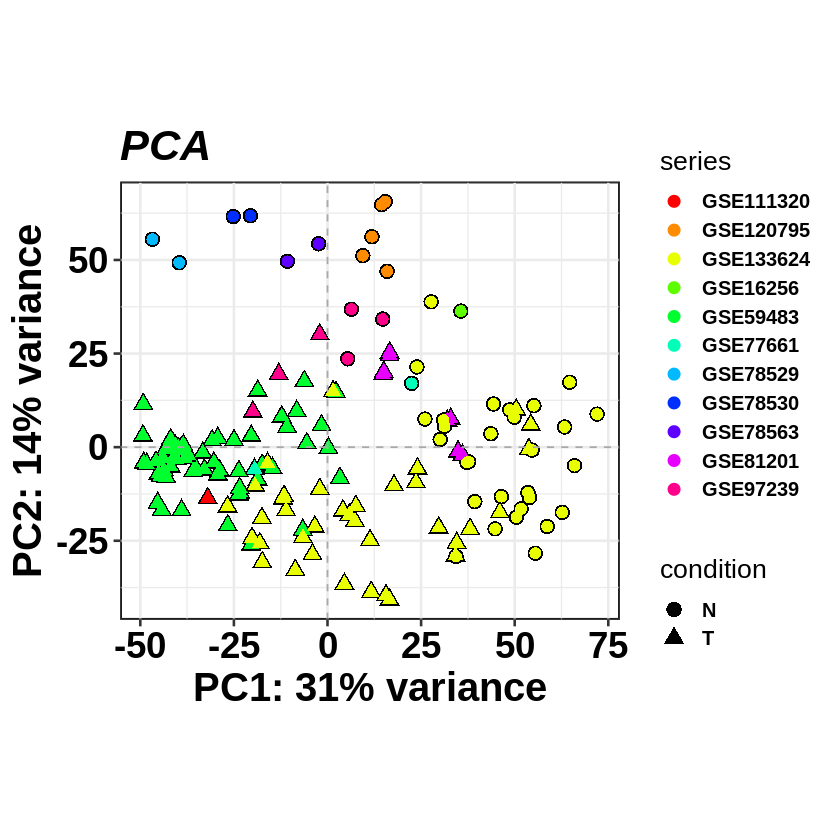

In [ ]:
#mycolors <- colorRampPalette(brewer.pal(8, "Set2"))(11)
#mycolors = cols25(11)
mycolors = rainbow(11)

#PCA
vsd <- vst(dga, blind=FALSE)
main.factor = "condition"
second.factor ="series"
pcaData <- plotPCA(vsd, intgroup=c(main.factor,ifelse(nchar(second.factor)>0,second.factor,NULL)),returnData=TRUE)

percentVar <- round(100 * attr(pcaData, "percentVar"))

PCA = ggplot(pcaData, aes(PC1, PC2, shape = condition, color=series)) +
geom_point(aes(shape = condition), size = 4, colour = "black") +
geom_point(aes(colour=series, shape = condition), size=3) + 
#geom_point(size=4, aes(color=series, shape = condition)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() + ggtitle("PCA")+theme(plot.title = element_text(hjust = 0.5)) +
  theme_bw(base_size = 16) + #+ theme(legend.position = "right") +
  geom_hline(yintercept=0, linetype="dashed", color = "darkgrey") +
  geom_vline(xintercept=0, linetype="dashed", color = "darkgrey") +
theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
      axis.text.x = element_text(angle = 0, face = "bold", color = "black", size=22, hjust =.5), 
      axis.title.x = element_text(face = "bold", color = "black", size = 24),
      axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=22),
      axis.title.y = element_text(face = "bold", color = "black", size = 24),
      legend.text = element_text(face = "bold", color = "black", size = 12),
      legend.position="right",
      panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
scale_color_manual(values=mycolors) #+ scale_shape_manual(values = c(21,24))

PCA
pdf(paste('PCA.pdf',sep=''),width=8, height=8)
plot(PCA)
dev.off()

In [ ]:
y <- DGEList(counts=fCountsData, genes = row.names(fCountsData))
# rpkm
fCountsCPM = cpm(y, log=T)
# filter for expression
keep <- rowSums(cpm(y)>1)>=40
yf <- y[keep,]

# calculate 500 most variant genes and 
# save their counts in fCountsRPKMTOP
N=500
vary <- apply(fCountsCPM[keep,],1,var)
vary_s <- sort(vary, decreasing = T)
TOP_N <- names(vary_s[1:N])
yTOP <-  y[TOP_N,]
fCountsCPMTOP <- fCountsCPM[TOP_N,]

In [ ]:
length(unique((annotation_column)$series))

[1] 11

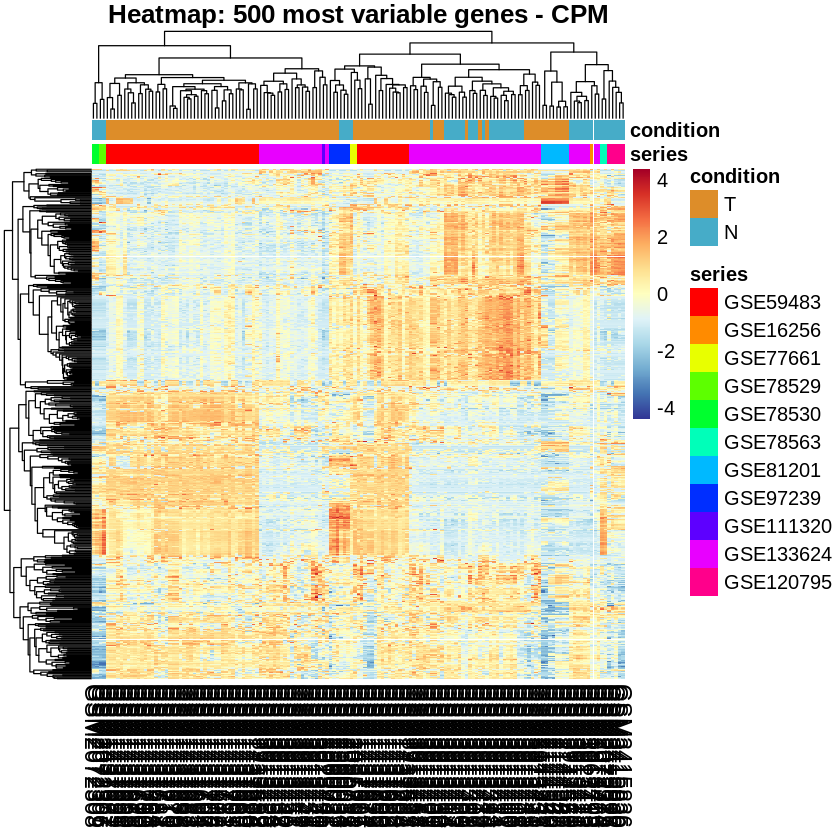

In [ ]:
annotation_column <- metadata_ArchS4[,3:dim(metadata_ArchS4)[2]-1]

 mycolors_c = wes_palette("FantasticFox1", n = 3)[c(1,3)]
 names(mycolors_c) <- unique((annotation_column)$condition)
 mycolors_s = rainbow(11) #as.character(glasbey(10))
 names(mycolors_s) <- unique((annotation_column)$series)
 
 ann_colors = list(
   condition = mycolors_c,
   series = mycolors_s
 )


#options(repr.plot.width=17, repr.plot.height=7)

colors <- colorRampPalette( rev(brewer.pal(11, "RdYlBu")) )(255)
#colors = magma(255)
HP <- pheatmap::pheatmap(fCountsCPMTOP,
                         scale = 'row',
                         annotation_col = annotation_column,
                         annotation_colors = ann_colors, 
                         cluster_rows = T, 
                         cluster_cols = T, 
                         main = 'Heatmap: 500 most variable genes - CPM',
                         show_rownames = F,
                         fontsize = 12, fontsize_row = 10, fontsize_col = 14, 
                         display_numbers = F, 
                         col=colors)

In [ ]:
# tumor vs healthy
alpha = 0.05
                          
res_TvsN <- results(dga, 
                    contrast = c("condition","T","N"), 
                    cooksCutoff          = Inf,
                    independentFiltering = TRUE,
                    alpha                = alpha,
                    pAdjustMethod        = "BH")

res_TvsN = res_TvsN[order(res_TvsN$pvalue, decreasing = F),]
summary(res_TvsN)

dgeResults = list()
dgeResults[['TvsN']] = res_TvsN


out of 18350 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6947, 38%
LFC < 0 (down)     : 3680, 20%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


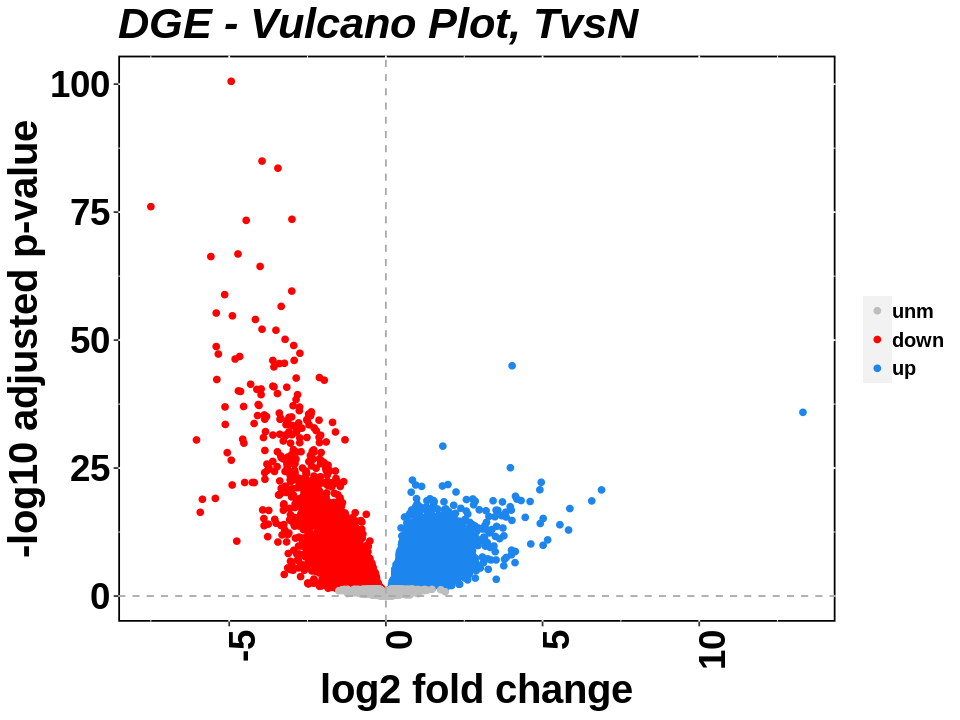

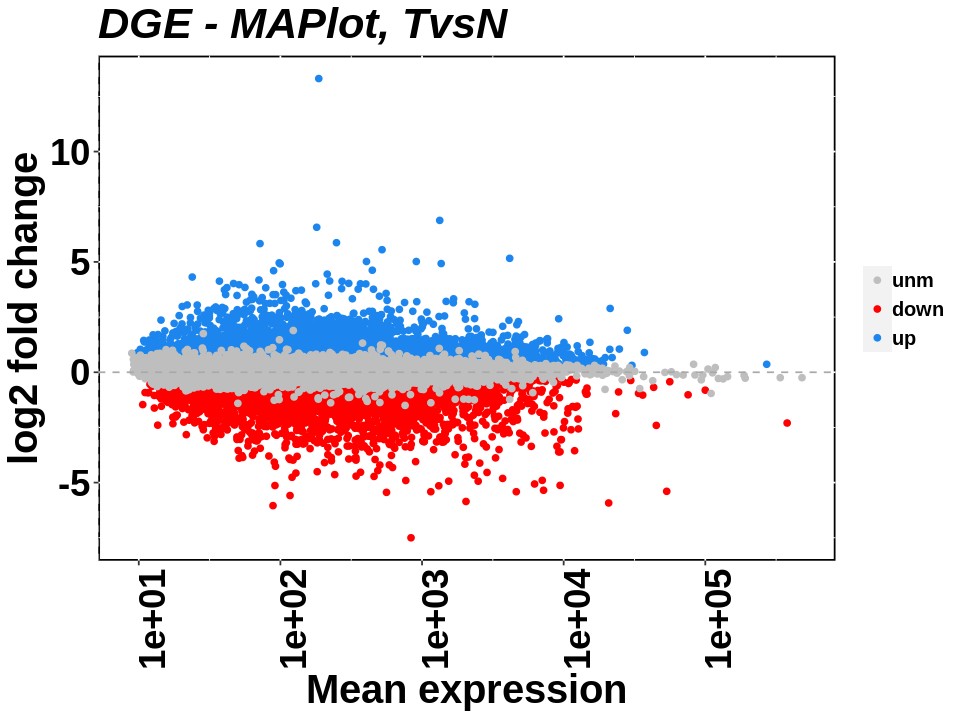

In [ ]:
for (i in names(dgeResults)) {
condition = i
results = as.data.frame(dgeResults[[i]])
results$gene = 'unm'
results[results$padj < alpha & !is.na(results$padj) & results$log2FoldChange > 0,]$gene = 'up'
results[results$padj < alpha & !is.na(results$padj) & results$log2FoldChange < 0,]$gene = 'down'
  
results$gene <- factor(x = results$gene, levels = c("unm", "down","up"))
    
options(repr.plot.width=8, repr.plot.height=6)
VP = ggplot(results) +
geom_point(aes(x=log2FoldChange, y=-log10(padj), color = gene)) +
ggtitle(paste("DGE - Vulcano Plot,", condition)) +
scale_color_manual(values = c('grey','red','dodgerblue2')) +
geom_hline(yintercept=0, linetype="dashed", color = "darkgrey") +
geom_vline(xintercept=0, linetype="dashed", color = "darkgrey") +
theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
      axis.text.x = element_text(angle = 90, face = "bold", color = "black", size=22, hjust =1), 
      axis.title.x = element_text(face = "bold", color = "black", size = 24),
      axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=22),
      axis.title.y = element_text(face = "bold", color = "black", size = 24),
      legend.text = element_text(face = "bold", color = "black", size = 12),
      legend.title = element_text(face = "bold", color = "black", size = 0),
      legend.position="right",
      panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
labs(x = "log2 fold change", y = "-log10 adjusted p-value")   
print(VP)
  #  jpeg(paste(dir,'VulcanoPlot_',condition,'_outliers.jpg',sep=''),width=800, height=800, unit='px')
    #plot(VP)
   # dev.off()
pdf(paste('VulcanoPlot_',condition,'.pdf',sep=''),width=8, height=8)
plot(VP)
dev.off()
 
MAplot = ggplot(results) +
geom_point(aes(x=baseMean, y=log2FoldChange, color = gene)) +
xlim(c(0,1.e5)) +
scale_x_continuous(trans='log10') +
ggtitle(paste("DGE - MAPlot,", condition)) +
scale_color_manual(values = c('grey','red','dodgerblue2')) +
geom_hline(yintercept=0, linetype="dashed", color = "darkgrey") +
geom_vline(xintercept=0, linetype="dashed", color = "darkgrey") +
theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
      axis.text.x = element_text(angle = 90, face = "bold", color = "black", size=22, hjust =1), 
      axis.title.x = element_text(face = "bold", color = "black", size = 24),
      axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=22),
      axis.title.y = element_text(face = "bold", color = "black", size = 24),
      legend.text = element_text(face = "bold", color = "black", size = 12),
      legend.title = element_text(face = "bold", color = "black", size = 0),
      legend.position="right",
      panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
labs(x = "Mean expression", y = "log2 fold change")  
print(MAplot)
    #jpeg(paste(dir,'MAplot_',condition,'_outliers.jpg',sep=''),width=800, height=800, unit='px')
    #plot(MAplot)
    #dev.off()
pdf(paste('MAplot_',condition,'.pdf',sep=''),width=8, height=8)
plot(MAplot)
dev.off()
}    
#pdf(paste('VulcanoPlot_',condition,'.pdf',sep=''),width=8, height=8)
#plot(VP)
#dev.off()
    

In [ ]:
fdrUP = list()

alpha = 0.05
fdrUP = lapply(names(dgeResults), 
               function(x) row.names(dgeResults[[x]])[dgeResults[[x]]$padj <= alpha & 
                                        !is.na(dgeResults[[x]]$padj)&
                                        dgeResults[[x]]$log2FoldChange > 0])
names(fdrUP)= names(dgeResults) 
fdrDW = lapply(names(dgeResults), 
               function(x) row.names(dgeResults[[x]])[dgeResults[[x]]$padj <= alpha & 
                                        !is.na(dgeResults[[x]]$padj)&
                                        dgeResults[[x]]$log2FoldChange < 0])
names(fdrDW)= names(dgeResults)  

In [ ]:
lengths(fdrUP)
lengths(fdrDW)

TvsN 
6947

TvsN 
3680

Identify proteins on the surface

In [ ]:
# Surfaceome  

for (i in names(dgeResults)) {
    print(i)
    
    #Add mean expression in CPM 
    dgeResults[[i]]$Mean_CPM_N = rowMeans(cpm[row.names(dgeResults[[i]]), 
                                              row.names(metadata_ArchS4[metadata_ArchS4$condition=='N',])])
    dgeResults[[i]]$Mean_CPM_T = rowMeans(cpm[row.names(dgeResults[[i]]), 
                                              row.names(metadata_ArchS4[metadata_ArchS4$condition=='T',])])
    # surface protein
    modulation = c('UP','DW')
    fdr = list(UP = fdrUP[[i]], DW = fdrDW[[i]])
    for (m in modulation) { 
        proteins = ST[ST$UniProt.gene %in% fdr[[m]],]
        proteins = proteins[!is.na(proteins$Surfaceome.Label),]
        print(table(proteins$Surfaceome.Label))
        surface.proteins = proteins[proteins$Surfaceome.Label=='surface',]
        surface.genes = surface.proteins$UniProt.gene
        surfaceome_DGEresults = as.data.frame(dgeResults[[i]][surface.genes,])
        surfaceome_DGEresults$GeneID = row.names(surfaceome_DGEresults)
        surfaceome_DGEresults$ProteinID = surface.proteins$UniProt.name
        surfaceome_DGEresults = surfaceome_DGEresults[order(surfaceome_DGEresults$log2FoldChange, decreasing = T),
                                                     c('GeneID','ProteinID', 
                                                       'Mean_CPM_T','Mean_CPM_N',
                                                       'log2FoldChange','padj')]
        write.xlsx(surfaceome_DGEresults,
               paste('DGE_BladderSurfaceome_',i,'_',m,'.xlsx',sep=''), 
               asTable = T, row.names= F) 
        write.xlsx(surface.proteins[surfaceome_DGEresults$ProteinID,], 
               paste('BladderSurfaceome_details',i,'_',m,'.xlsx', sep =''), 
               asTable = T, row.names= F)  
        }
    }

[1] "TvsN"

nonsurface    surface 
       716        434 

nonsurface    surface 
       309        679 


Additional plotting

# Intersection

In [ ]:
t = 0
#Merge_up = read.xlsx('Include_TCGA/DGE_BladderSurfaceome_TvsN_UP.xlsx')
GEO_up = read.xlsx('DGE_BladderSurfaceome_TvsN_UP.xlsx')
TCGA_up = read.xlsx('../TCGA/DGE_BladderSurfaceome_TP_vs_NT_UP.xlsx')
GSE133624_up = read.xlsx('GSE133624/DGE_BladderSurfaceome_TvsN_UP.xlsx')
GSE97239_up = read.xlsx('GSE97239/DGE_BladderSurfaceome_TvsN_UP.xlsx')

UP = list(#MergeAll = Merge_up[Merge_up$log2FoldChange >t,]$ProteinID,
          MergeGEO = GEO_up[GEO_up$log2FoldChange >t,]$ProteinID, 
          TCGA = TCGA_up[TCGA_up$log2FoldChange >t,]$ProteinID, 
          GSE133624 = GSE133624_up[GSE133624_up$log2FoldChange >t,]$ProteinID, 
          GSE97239 = GSE97239_up[GSE97239_up$log2FoldChange >t,]$ProteinID )

#Merge_dw = read.xlsx('Include_TCGA/DGE_BladderSurfaceome_TvsN_DW.xlsx')
GEO_dw = read.xlsx('DGE_BladderSurfaceome_TvsN_DW.xlsx')
TCGA_dw = read.xlsx('../TCGA/DGE_BladderSurfaceome_TP_vs_NT_DW.xlsx')
GSE133624_dw = read.xlsx('GSE133624/DGE_BladderSurfaceome_TvsN_DW.xlsx')
GSE97239_dw = read.xlsx('GSE97239/DGE_BladderSurfaceome_TvsN_DW.xlsx')

DW = list(#MergeAll = Merge_dw[Merge_dw$log2FoldChange < -t,]$ProteinID,
          MergeGEO = GEO_dw[GEO_dw$log2FoldChange < -t,]$ProteinID, 
          TCGA = TCGA_dw[TCGA_dw$log2FoldChange < -t,]$ProteinID,
           GSE133624 =  GSE133624_dw[GSE133624_dw$log2FoldChange < -t,]$ProteinID,
          GSE97239 = GSE97239_dw[GSE97239_dw$log2FoldChange < -t,]$ProteinID)





In [ ]:
library(venn)
venn(UP,
     simplify=F, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(4), ilcs = 1.5, sncs = 2)

In [ ]:
Venn_protein = Reduce(intersect,UP)

In [ ]:
venn(list(GEO_UP = GEO_up[GEO_up$log2FoldChange >t,]$ProteinID, 
     TCGA_DOWN = TCGA_dw[TCGA_dw$log2FoldChange < -t,]$ProteinID,
     GSE133624_DW =  GSE133624_dw[GSE133624_dw$log2FoldChange < -t,]$ProteinID,
         GSE97239 = GSE97239_dw[GSE97239_dw$log2FoldChange < -t,]$ProteinID),
     simplify=F, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(4), ilcs = 1.5, sncs = 2)

venn(list(GEO_DW = GEO_dw[GEO_dw$log2FoldChange < -t,]$ProteinID, 
     TCGA_UP = TCGA_up[TCGA_up$log2FoldChange >t,]$ProteinID),
     simplify=F, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(4), ilcs = 1.5, sncs = 2)

In [ ]:
mag41=Reduce(intersect, UP)
mag21 = read.xlsx('../IntersectionVenn/mag21.xlsx')$ProteinID
setdiff(mag41, mag21)

# Analysis including TCGA

In [ ]:
dir = 'Include_TCGA/'
dir.create(dir)
TCGAcount = read.table('../BLCA_TCGA_expression2.tsv')
metadata_TCGA = read.table('../BLCA_TCGA_metadata.tsv', sep = '\t')

# check genes
TCGAgenes = row.names(TCGAcount)
#venn(list(TCGA= TCGAgenes, ARCHS4 = genes),  
#     simplify=TRUE, opacity = 0.3, box = FALSE, ilab=TRUE, zcolor = c('blue','red'), ilcs = 1.5, sncs = 2)

common_gene = intersect(genes, TCGAgenes)
TCGA_common = TCGAcount[common_gene,]
ARCHS4_common = fCountsData[common_gene,]  
# matrix
M = cbind(ARCHS4_common, TCGA_common)
# metadata
metadata_clean = data.frame(samples   = c(metadata_ArchS4$samples, as.character(metadata_TCGA$barcode)),
                            condition = c(metadata_ArchS4$condition, substring(metadata_TCGA$shortLetterCode,1,1)),
                            series    = c(metadata_ArchS4$series, rep("TCGA", length(metadata_TCGA$barcode))))

Warning message in dir.create(dir):
“'Include_TCGA' already exists”


ERROR: Error in intersect(genes, TCGAgenes): object 'genes' not found


In [ ]:
# perform DGE
design.formula = as.formula("~condition+series")
dds <- DESeqDataSetFromMatrix(countData = M,
                              colData = metadata_clean,
                              design = design.formula)


# FILTER FOR GENE EXPRESSION 
min.samples = 59
keep <- rowSums(cpm(counts(dds)) >= 1) >= min.samples
table(keep)
dds <- dds[keep,]

cpm = cpm(counts(dds), log = F)

#DGE
dga <- DESeq(object = dds, 
             test = "Wald", 
             fitType = "parametric", 
             betaPrior = FALSE,
             minReplicatesForReplace = Inf)
#Dispersion plot
plotDispEsts(dga)

In [ ]:
#PCA
vsd <- vst(dga, blind=FALSE)
main.factor = "condition"
second.factor ="series"
pcaData <- plotPCA(vsd, intgroup=c(main.factor,ifelse(nchar(second.factor)>0,second.factor,NULL)),returnData=TRUE)

percentVar <- round(100 * attr(pcaData, "percentVar"))

PCA = ggplot(pcaData, aes(PC1, PC2, shape = condition, color=series)) +
geom_point(aes(shape = condition), size = 4, colour = "black") +
geom_point(aes(colour=series, shape = condition), size=3) + 
#geom_point(size=4, aes(color=series, shape = condition)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() + ggtitle("PCA")+theme(plot.title = element_text(hjust = 0.5)) +
  theme_bw(base_size = 16) + #+ theme(legend.position = "right") +
  geom_hline(yintercept=0, linetype="dashed", color = "darkgrey") +
  geom_vline(xintercept=0, linetype="dashed", color = "darkgrey") +
theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
      axis.text.x = element_text(angle = 0, face = "bold", color = "black", size=22, hjust =.5), 
      axis.title.x = element_text(face = "bold", color = "black", size = 24),
      axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=22),
      axis.title.y = element_text(face = "bold", color = "black", size = 24),
      legend.text = element_text(face = "bold", color = "black", size = 12),
      legend.position="right",
      panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
scale_color_manual(values=rainbow(12)) #+ scale_shape_manual(values = c(21,24))


PCA
pdf(paste(dir,'PCA.pdf',sep=''),width=8, height=8)
plot(PCA)
dev.off()

In [ ]:
# tumor vs healthy
alpha = 0.05
                          
res_TvsN <- results(dga, 
                    contrast = c("condition","T","N"), 
                    cooksCutoff          = Inf,
                    independentFiltering = TRUE,
                    alpha                = alpha,
                    pAdjustMethod        = "BH")

res_TvsN = res_TvsN[order(res_TvsN$pvalue, decreasing = F),]
summary(res_TvsN)

dgeResults = list()
dgeResults[['TvsN']] = res_TvsN

In [ ]:
fdrUP = list()

alpha = 0.05
fdrUP = lapply(names(dgeResults), 
               function(x) row.names(dgeResults[[x]])[dgeResults[[x]]$padj <= alpha & 
                                        !is.na(dgeResults[[x]]$padj)&
                                        dgeResults[[x]]$log2FoldChange > 0])
names(fdrUP)= names(dgeResults) 
fdrDW = lapply(names(dgeResults), 
               function(x) row.names(dgeResults[[x]])[dgeResults[[x]]$padj <= alpha & 
                                        !is.na(dgeResults[[x]]$padj)&
                                        dgeResults[[x]]$log2FoldChange < 0])
names(fdrDW)= names(dgeResults)  

In [ ]:
# Surfaceome  

for (i in names(dgeResults)) {
    print(i)
    
    #Add mean expression in CPM 
    dgeResults[[i]]$Mean_CPM_N = rowMeans(cpm[row.names(dgeResults[[i]]), 
                                              row.names(metadata_ArchS4[metadata_ArchS4$condition=='N',])])
    dgeResults[[i]]$Mean_CPM_T = rowMeans(cpm[row.names(dgeResults[[i]]), 
                                              row.names(metadata_ArchS4[metadata_ArchS4$condition=='T',])])
    # surface protein
    modulation = c('UP','DW')
    fdr = list(UP = fdrUP[[i]], DW = fdrDW[[i]])
    for (m in modulation) { 
        proteins = ST[ST$UniProt.gene %in% fdr[[m]],]
        proteins = proteins[!is.na(proteins$Surfaceome.Label),]
        print(table(proteins$Surfaceome.Label))
        surface.proteins = proteins[proteins$Surfaceome.Label=='surface',]
        surface.genes = surface.proteins$UniProt.gene
        surfaceome_DGEresults = as.data.frame(dgeResults[[i]][surface.genes,])
        surfaceome_DGEresults$GeneID = row.names(surfaceome_DGEresults)
        surfaceome_DGEresults$ProteinID = surface.proteins$UniProt.name
        surfaceome_DGEresults = surfaceome_DGEresults[order(surfaceome_DGEresults$log2FoldChange, decreasing = T),
                                                     c('GeneID','ProteinID', 
                                                       'baseMean','Mean_CPM_T','Mean_CPM_N',
                                                       'log2FoldChange','lfcSE','stat','pvalue','padj')]
        write.xlsx(surfaceome_DGEresults,
               paste(dir,'DGE_BladderSurfaceome_',i,'_',m,'.xlsx',sep=''), 
               asTable = T, row.names= F) 
        write.xlsx(surface.proteins[surfaceome_DGEresults$ProteinID,], 
               paste(dir,'BladderSurfaceome_details',i,'_',m,'.xlsx', sep =''), 
               asTable = T, row.names= F)  
        }
    }

In [ ]:
outersect <- function(x, y) {
  sort(c(x[!x%in%y],
         y[!y%in%x]))
}

single.l=list()
only2.l = list()
list_2_use = UP
for (i in names(list_2_use)){
    only1 = setdiff(list_2_use[[i]],unique(as.character(unlist(list_2_use[outersect(names(list_2_use),i)]))))
    single.l[[i]] = only1
    for (j in names(list_2_use)) {
        if (j!=i) {
            only2 = setdiff(intersect(list_2_use[[i]],list_2_use[[j]]),Reduce(intersect, list_2_use))
            only2.l[[paste(i,j)]] = only2
        }
    }
}

only1_UP = single.l
only2_UP = only2.l

single.l=list()
only2.l = list()
list_2_use = DW
for (i in names(list_2_use)){
    only1 = setdiff(list_2_use[[i]],unique(as.character(unlist(list_2_use[outersect(names(list_2_use),i)]))))
    single.l[[i]] = only1
    for (j in names(list_2_use)) {
        if (j!=i) {
            only2 = setdiff(intersect(list_2_use[[i]],list_2_use[[j]]),Reduce(intersect, list_2_use))
            only2.l[[paste(i,j)]] = only2
        }
    }
}

only1_DW = single.l
only2_DW = only2.l

# Function to reanalize results from 1 series

In [ ]:
# function to analyze separately a single GEO series
GSE_DGE = function(count, metadata, Series, alpha = 0.05) {
    dir = paste(Series,'/',sep ='')
    dir.create(dir)
    metadata_s = metadata[metadata$series == Series,]
    count_s = count[,metadata_s$samples]
    design.formula = as.formula("~condition")
    
    dds <- DESeqDataSetFromMatrix(countData = count_s,
                                  colData = metadata_s,
                                  design = design.formula)
    
    min.sample = as.numeric(table(metadata_s$condition)[1])
    print(min.sample)
    keep <- rowSums(cpm(counts(dds)) >= 1) >= min.sample
    print(table(keep))
    dds <- dds[keep,]
    
    cpm = cpm(counts(dds), log = F)
    
    #DGE
    dga <- DESeq(object = dds, 
             test = "Wald", 
             fitType = "parametric", 
             betaPrior = FALSE,
             minReplicatesForReplace = Inf)
    
    dgeResults = list()
    dgeResults[['TvsN']] <- results(dga, 
                    contrast = c("condition","T","N"), 
                    cooksCutoff          = Inf,
                    independentFiltering = TRUE,
                    alpha                = alpha,
                    pAdjustMethod        = "BH")

    dgeResults[['TvsN']] = dgeResults[['TvsN']][order(dgeResults[['TvsN']]$pvalue, decreasing = F),]
    print(summary(dgeResults[['TvsN']]))
    fdrUP = list()
    fdrUP = lapply(names(dgeResults), 
               function(x) row.names(dgeResults[[x]])[dgeResults[[x]]$padj <= alpha & 
                                        !is.na(dgeResults[[x]]$padj)&
                                        dgeResults[[x]]$log2FoldChange > 0])
    names(fdrUP)= names(dgeResults) 
    fdrDW = lapply(names(dgeResults), 
               function(x) row.names(dgeResults[[x]])[dgeResults[[x]]$padj <= alpha & 
                                        !is.na(dgeResults[[x]]$padj)&
                                        dgeResults[[x]]$log2FoldChange < 0])
    names(fdrDW)= names(dgeResults)  
    for (i in names(dgeResults)) {
    print(i)
    
    #Add mean expression in CPM 
    dgeResults[[i]]$Mean_CPM_N = rowMeans(cpm[row.names(dgeResults[[i]]), 
                                              row.names(metadata_s[metadata_s$condition=='N',])])
    dgeResults[[i]]$Mean_CPM_T = rowMeans(cpm[row.names(dgeResults[[i]]), 
                                              row.names(metadata_s[metadata_s$condition=='T',])])
    # surface protein
    modulation = c('UP','DW')
    fdr = list(UP = fdrUP[[i]], DW = fdrDW[[i]])
    for (m in modulation) { 
        proteins = ST[ST$UniProt.gene %in% fdr[[m]],]
        proteins = proteins[!is.na(proteins$Surfaceome.Label),]
        print(table(proteins$Surfaceome.Label))
        surface.proteins = proteins[proteins$Surfaceome.Label=='surface',]
        surface.genes = surface.proteins$UniProt.gene
        surfaceome_DGEresults = as.data.frame(dgeResults[[i]][surface.genes,])
        surfaceome_DGEresults$GeneID = row.names(surfaceome_DGEresults)
        surfaceome_DGEresults$ProteinID = surface.proteins$UniProt.name
        surfaceome_DGEresults = surfaceome_DGEresults[order(surfaceome_DGEresults$log2FoldChange, decreasing = T),
                                                     c('GeneID','ProteinID', 
                                                       'Mean_CPM_T','Mean_CPM_N',
                                                       'log2FoldChange','padj')]
        write.xlsx(surfaceome_DGEresults,
               paste(dir,'DGE_BladderSurfaceome_',i,'_',m,'.xlsx',sep=''), 
               asTable = T, row.names= F) 
        write.xlsx(surface.proteins[surfaceome_DGEresults$ProteinID,], 
               paste(dir,'BladderSurfaceome_details',i,'_',m,'.xlsx', sep =''), 
               asTable = T, row.names= F)  
        }
    }
                   return(dgeResults[[i]])
}

In [ ]:
# 3vs3
GSE_DGE(count = fCountsData, metadata = metadata_ArchS4, Series = 'GSE97239')
# Dr Stay
GSE_DGE(count = fCountsData, metadata = metadata_ArchS4, Series = 'GSE133624')

Warning message in dir.create(dir):
“'GSE97239' already exists”
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 3
keep
FALSE  TRUE 
15058 20180 


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 20180 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 933, 4.6%
LFC < 0 (down)     : 801, 4%
outliers [1]       : 0, 0%
low counts [2]     : 5478, 27%
(mean count < 15)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "TvsN"

nonsurface    surface 
       159         94 

nonsurface    surface 
        75        103 


log2 fold change (MLE): condition T vs N 
Wald test p-value: condition T vs N 
DataFrame with 20180 rows and 8 columns
                      baseMean        log2FoldChange             lfcSE
                     <numeric>             <numeric>         <numeric>
PGM5          1647.72063216967     -5.26787162680737 0.573117773630022
FHL1          389.677780838939     -4.98011218239609 0.558565911624734
ATF3          603.124340463727     -4.27904229340246 0.494684102677795
DUSP2         457.737554236296     -3.85830661143543 0.459200824553363
PI16           122.36781642286     -4.60527603459959 0.553153355721032
...                        ...                   ...               ...
CD8B          10.3154975477403  0.000421114825641014 0.762971513633375
SLC26A10      16.2636490213167  0.000308876477798886 0.616338013971464
SPACA6        45.3315809988541 -0.000221145479636676   0.5417030467585
SERPINI1      3.50303609115332  0.000354352783118998  1.18512199018888
RP11-390M11.1 5.2023899206996

Warning message in dir.create(dir):
“'GSE133624' already exists”
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 29
keep
FALSE  TRUE 
19285 15953 


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 15953 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5639, 35%
LFC < 0 (down)     : 3147, 20%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "TvsN"

nonsurface    surface 
       582        316 

nonsurface    surface 
       290        596 


log2 fold change (MLE): condition T vs N 
Wald test p-value: condition T vs N 
DataFrame with 15953 rows and 8 columns
                 baseMean        log2FoldChange              lfcSE
                <numeric>             <numeric>          <numeric>
PI16     1881.29067222159      -7.6799488308056  0.388335012122921
CFD      4454.58619014621     -4.94106224121315  0.277422374658565
SCARA5   1832.11017128584     -5.47465395995486  0.344541299006145
C16ORF89 209.379606724543     -4.13002768751429  0.263121398965029
FAM107A  837.854492311905     -4.62552718667721  0.298930124809639
...                   ...                   ...                ...
DNHD1    459.781060293552  0.000291312979710032  0.195015291462384
TEC      110.121190571217  0.000154031953193894  0.160877063781735
GIGYF2   1771.85588706958 -6.57218877270669e-05 0.0874334295827338
WBP2NL   55.5123351930415  7.40518129570345e-05  0.223844231861833
ASB9     64.9618877414605 -5.25214166821504e-05  0.247578467787097
          

# Summarise results

In [ ]:
# threshold 
t = 0
# import UP results in dataframe
GEO_up       = read.xlsx('DGE_BladderSurfaceome_TvsN_UP.xlsx')
TCGA_up      = read.xlsx('../TCGA/DGE_BladderSurfaceome_TP_vs_NT_UP.xlsx')
GSE133624_up = read.xlsx('GSE133624/DGE_BladderSurfaceome_TvsN_UP.xlsx')
NMIBC_up = read.xlsx('../GSE133624_Archs4/DGE_BladderSurfaceome_NMIBC_vs_CTL_UP.xlsx')
MIBC_up = read.xlsx('../GSE133624_Archs4/DGE_BladderSurfaceome_MIBC_vs_CTL_UP.xlsx')
GSE97239_up  = read.xlsx('GSE97239/DGE_BladderSurfaceome_TvsN_UP.xlsx')

UP_list = list(MergeGEO   = GEO_up,
               TCGA       = TCGA_up,
               GSE97239   = GSE97239_up,
               GSE133624  = GSE133624_up,
               MIBCvsCTL  = MIBC_up,
               NMIBCvsCTL = NMIBC_up)
               
# save ProteinID in a list
UP_Proteins = list(MergeGEO   = GEO_up[GEO_up$log2FoldChange > t,]$ProteinID, 
                   TCGA       = TCGA_up[TCGA_up$log2FoldChange > t,]$ProteinID, 
                   GSE133624  = GSE133624_up[GSE133624_up$log2FoldChange > t,]$ProteinID, 
                   GSE97239   = GSE97239_up[GSE97239_up$log2FoldChange > t,]$ProteinID,
                   MIBCvsCTL  = MIBC_up[MIBC_up$log2FoldChange > t,]$ProteinID,
                   NMIBCvsCTL = NMIBC_up[NMIBC_up$log2FoldChange > t,]$ProteinID)
                   


GEO_dw       = read.xlsx('DGE_BladderSurfaceome_TvsN_DW.xlsx')
TCGA_dw      = read.xlsx('../TCGA/DGE_BladderSurfaceome_TP_vs_NT_DW.xlsx')
GSE133624_dw = read.xlsx('GSE133624/DGE_BladderSurfaceome_TvsN_DW.xlsx')
GSE97239_dw  = read.xlsx('GSE97239/DGE_BladderSurfaceome_TvsN_DW.xlsx')
NMIBC_dw = read.xlsx('../GSE133624_Archs4/DGE_BladderSurfaceome_NMIBC_vs_CTL_DW.xlsx')
MIBC_dw = read.xlsx('../GSE133624_Archs4/DGE_BladderSurfaceome_MIBC_vs_CTL_DW.xlsx')

DW_list = list(MergeGEO   = GEO_dw,
               TCGA       = TCGA_dw,
               GSE97239   = GSE97239_dw,
               GSE133624  = GSE133624_dw,
               MIBCvsCTL  = MIBC_dw,
               NMIBCvsCTL = NMIBC_dw)

DW_Proteins = list(MergeGEO   = GEO_dw[GEO_dw$log2FoldChange < -t,]$ProteinID, 
                   TCGA       = TCGA_dw[TCGA_dw$log2FoldChange < -t,]$ProteinID,
                   GSE133624  = GSE133624_dw[GSE133624_dw$log2FoldChange < -t,]$ProteinID,
                   GSE97239   = GSE97239_dw[GSE97239_dw$log2FoldChange < -t,]$ProteinID,
                   MIBCvsCTL  = MIBC_dw[MIBC_dw$log2FoldChange < -t,]$ProteinID,
                   NMIBCvsCTL = NMIBC_dw[NMIBC_dw$log2FoldChange < -t,]$ProteinID)




In [ ]:
pdf(paste('Venn_intersection_UP.pdf',sep=''),width=8, height=8)
venn(UP_Proteins[1:4],
     simplify=T, opacity = 0.3, box = FALSE, ilab=TRUE, ellipse = F, 
     zcolor = rainbow(4), ilcs = 1.5, sncs = 1.5)

dev.off()

pdf 
  2

In [ ]:
pdf(paste('Venn_intersection_DW.pdf',sep=''),width=8, height=8)
venn(DW_Proteins[1:4],
     simplify=T, opacity = 0.3, box = FALSE, ilab=TRUE, ellipse = F, 
     zcolor = rainbow(4), ilcs = 1.5, sncs = 1.5)

dev.off()

pdf 
  2

In [ ]:
venn(list(GEO_UP       = GEO_up[GEO_up$log2FoldChange >t,]$ProteinID, 
          TCGA_DOWN    = TCGA_dw[TCGA_dw$log2FoldChange < -t,]$ProteinID,
          GSE133624_DW = GSE133624_dw[GSE133624_dw$log2FoldChange < -t,]$ProteinID,
          GSE97239_DW  = GSE97239_dw[GSE97239_dw$log2FoldChange < -t,]$ProteinID),
     simplify=TRUE, opacity = 0.3, box = FALSE,  ilab=TRUE,
     zcolor = rainbow(4), ilcs = 1.5, sncs = 1.5)

venn(list(GEO_DW       = GEO_dw[GEO_dw$log2FoldChange < -t,]$ProteinID, 
          TCGA_UP      = TCGA_up[TCGA_up$log2FoldChange >t,]$ProteinID,
          GSE133624_UP = GSE133624_up[GSE133624_up$log2FoldChange > t,]$ProteinID,
          GSE97239_UP  = GSE97239_up[GSE97239_up$log2FoldChange > t,]$ProteinID),
     simplify=TRUE, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(4), ilcs = 1.5, sncs = 1.5)

In [ ]:
table(Results_GEO$ProteinID %in% UP_Proteins[['TCGA']])

In [ ]:
outersect <- function(x, y) {
  sort(c(x[!x%in%y],
         y[!y%in%x]))
}

single.l=list()
list_2_use = list(GEO_UP       = GEO_up[GEO_up$log2FoldChange >t,]$ProteinID, 
                  TCGA_DOWN    = TCGA_dw[TCGA_dw$log2FoldChange < -t,]$ProteinID,
                  GSE133624_DW = GSE133624_dw[GSE133624_dw$log2FoldChange < -t,]$ProteinID,
                  GSE97239_DW  = GSE97239_dw[GSE97239_dw$log2FoldChange < -t,]$ProteinID)
for (i in names(list_2_use)){
    only1 = setdiff(list_2_use[[i]],unique(as.character(unlist(list_2_use[outersect(names(list_2_use),i)]))))
    single.l[[i]] = only1
}

Geo_UP_only = single.l[['GEO_UP']]
row.names(GEO_up) <- GEO_up$ProteinID

Results_GEO = GEO_up[Geo_UP_only,c('GeneID','ProteinID','Mean_CPM_T','Mean_CPM_N','log2FoldChange','padj')]
Results_GEO$inTCGA = Results_GEO$ProteinID %in% UP_Proteins[['TCGA']]
Results_GEO$inGSE133624 = Results_GEO$ProteinID %in% UP_Proteins[['GSE133624']]
Results_GEO$MIBCvsCTL = Results_GEO$ProteinID %in% UP_Proteins[['MIBCvsCTL']]
Results_GEO$NMIBCvsCTL = Results_GEO$ProteinID %in% UP_Proteins[['NMIBCvsCTL']]
Results_GEO$inGSE97239 = Results_GEO$ProteinID %in% UP_Proteins[['GSE97239']]
write.xlsx(Results_GEO, 'Results_GEO_UP.xlsx', asTable = T, row.names = F)


# Annotation

In [ ]:
users = c('maurizio.aurora','tascini.annasofia')
user = users[2]
Rdir = "6_IntersectionProteins/"

lf <- list.files(paste("/Users/tascini.annasofia/Dropbox (HSR Global)/WORKSPACE/Menarini/Menarini_BladderSurfaceome/Results/",
                 Rdir,sep=''), 
                 pattern=glob2rx("DGE_*.xlsx"))

print(paste0("List of files: ", lf))

for (file in lf) {
  
  filename = tools::file_path_sans_ext(file)
  #filename = "DGE_BladderSurfaceome_TvsN_DW.xlsx"
  print(paste0("File name: ", filename))
  
  infile <- paste("/Users/",user,"/Dropbox (HSR Global)/WORKSPACE/Menarini/Menarini_BladderSurfaceome/Results/",
                  Rdir,
                  filename,".xlsx",sep="")
  #print(paste0("Input file: ", infile))
  outfile <- paste("/Users/",user,"/Dropbox (HSR Global)/WORKSPACE/Menarini/Menarini_BladderSurfaceome/Results/",
                   Rdir,
                   filename,".description.xlsx",sep="")
  
  
  #read dge file
  #DGE <- read.xlsx("/Users/maurizio.aurora/Dropbox (HSR Global)/WORKSPACE/Menarini/Menarini_BladderSurfaceome/DGE_BladderSurfaceome_MIBC_vs_CTL_DW_GSE133624_Archs4.xlsx")
  DGE <- read.xlsx(infile)
  #colnames(DGE) = c("GeneID","baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","Mean_TP","Mean_NT","ProteinID")
  
  
  ANNOTATE <- function(annotation, DGE) {
    
    #annotation="KEGG_2019_Human.txt"
    #annoname = tools::file_path_sans_ext("KEGG_2019_Human.txt")
    annoname = tools::file_path_sans_ext(annotation)
    print(annoname)
    inanno <- paste("/Users/",user,"/Dropbox (HSR Global)/WORKSPACE/Menarini/Menarini_BladderSurfaceome/Annotation/",
                    annotation,sep="")
    annotation_table=read.delim(inanno, header = FALSE, sep= "\t", fill = TRUE)
    head(annotation_table$V3)
    tail(annotation_table$V1, 1)
    annotation_table_no_v1 = subset(annotation_table, select = -c(V1))
    colNames = colnames(annotation_table_no_v1) # could be any number of column names here
    head(annotation_table_no_v1)
    #annotation_table$test = apply(annotation_table_no_v1[,colNames, drop = F], MARGIN = 1, FUN = function(i) paste(i, collapse = " "))
    annotation_table['test']=col_concat(annotation_table_no_v1, sep = " ")
    annotation_table['GeneID'] <- trimws(annotation_table$test, which = c("both"))
    #annotation_table['GeneID'] <- trimws(annotation_table$GeneID, which = c("left"))
    #annotation_table['V1'] <- trimws(annotation_table$V1, which = c("left"))
    head(annotation_table)
    head(annotation_table$V1)
    annotation_table_sub=annotation_table[,c("V1","GeneID")]
    colnames(annotation_table_sub)  
    head(annotation_table_sub)
    exploded = separate_rows(annotation_table_sub, GeneID, sep = " ", convert = FALSE)
    tail(exploded, 2)
    #group by gene.. that is: one gene x row with associated all the descriptions (space separated)
    grouped  <- exploded %>%
      group_by(GeneID) %>%
      summarise(temp = toString(V1)) %>%
      ungroup()
    
    colnames(grouped)=c("GeneID",annoname)

    merged <- merge(DGE, grouped, by="GeneID", all.x = TRUE)
    
    merged_subset = subset(merged, select =c("GeneID",annoname))
    return(merged_subset)
  }
  
  Kegg=ANNOTATE("KEGG_2019_Human.txt", DGE)
  Omim_Disease= ANNOTATE("OMIM_Disease.txt", DGE)
  OMIM_Expanded= ANNOTATE("OMIM_Expanded.txt", DGE)
  ClinVar_2019= ANNOTATE("ClinVar_2019.txt", DGE)  
  Jensen_DISEASES= ANNOTATE("Jensen_DISEASES.txt", DGE)   
  WikiPathways_2019_Human= ANNOTATE("WikiPathways_2019_Human.txt", DGE)  
  
  m0=merge(DGE, Kegg, by="GeneID", all.x = TRUE)
  m1=merge(m0, Omim_Disease, by="GeneID", all.x = TRUE)
  m2=merge(m1, OMIM_Expanded, by="GeneID", all.x = TRUE)
  m3=merge(m2, ClinVar_2019, by="GeneID", all.x = TRUE)
  m4=merge(m3, Jensen_DISEASES, by="GeneID", all.x = TRUE)
  m5=merge(m4, WikiPathways_2019_Human, by="GeneID", all.x = TRUE)
  head(m5)
    
  PD = ST[ST$UniProt.gene %in% m5$GeneID,] 
  PD_sub = PD[,c('UniProt.gene','UniProt.description',
                                    'Surfaceome.Label',
                                    'Membranome.Almen.main-class','Membranome.Almen.sub-class',
                                    'UniProt.subcellular','UniProt.keywords','COMPARTMENTS.link',
                                    'DrugBank.approved.drug.IDs')]
    colnames(PD_sub) = c('GeneID','Description',
                                    'Surfaceome.Label',
                                    'Almen.main-class','Almen.sub-class',
                                    'UniProt.subcellular','UniProt.keywords','COMPARTMENTS',
                                    'DrugBank.approved.drug.IDs')  
    details_merge = merge(m5,PD_sub, by = 'GeneID',all.x = TRUE)
    
    write.xlsx(details_merge, outfile, rownames = F, asTable= T)

  #write.xlsx(m5,file=sub(pattern=".txt$", replacement="_test.txt", x=outfile, asTable = T))

}


[1] "List of files: DGE_Intersection_DOWN_75.xlsx"
[2] "List of files: DGE_Intersection_UP_43.xlsx"  
[1] "File name: DGE_Intersection_DOWN_75"
[1] "KEGG_2019_Human"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "OMIM_Disease"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "OMIM_Expanded"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "ClinVar_2019"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "Jensen_DISEASES"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "WikiPathways_2019_Human"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "File name: DGE_Intersection_UP_43"
[1] "KEGG_2019_Human"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "OMIM_Disease"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "OMIM_Expanded"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "ClinVar_2019"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "Jensen_DISEASES"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "WikiPathways_2019_Human"


`summarise()` ungrouping output (override with `.groups` argument)



In [ ]:
mag43 = Reduce(intersect, UP_Proteins[1:4])
mag43_l = list()
for (set in names(UP_list)) {
    mag43_l[[set]] = UP_list[[set]][UP_list[[set]]$ProteinID %in% mag43, ]
}
write.xlsx(mag43_l, 'Results_Intersection_43.xlsx', asTable = T, row.names = F)

[1] "MergeGEO"
[1] "TCGA"
[1] "GSE97239"
[1] "GSE133624"


pdf 
  2

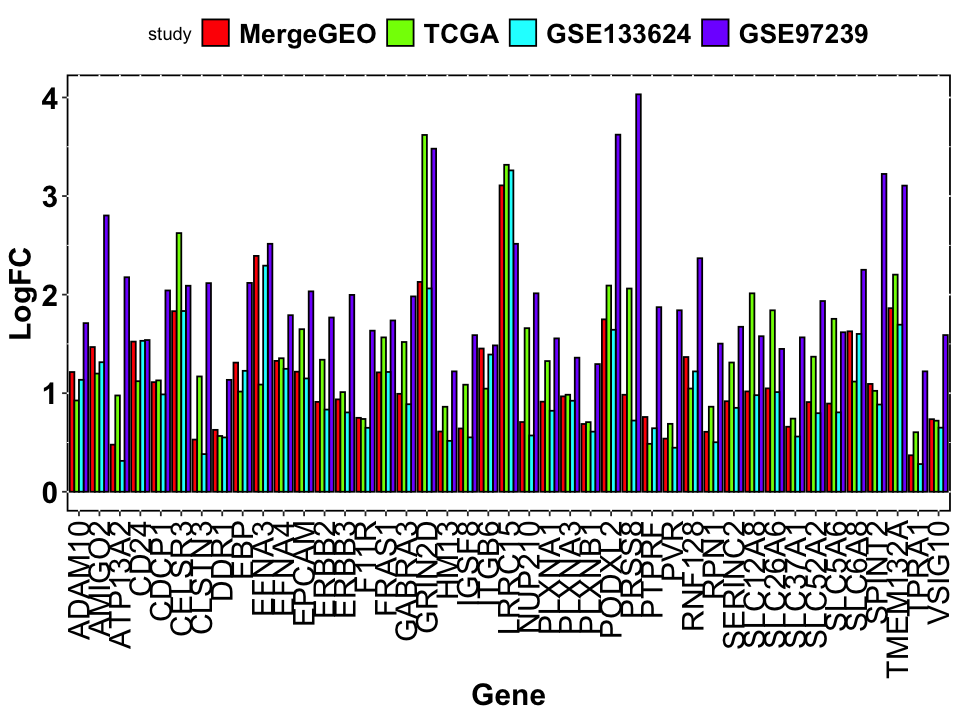

In [ ]:
df = data.frame()
for (i in names(mag43_l[1:4])) {
    print(i)
    df.tmp =  as.data.frame(mag43_l[i])
    df.tmp$study = i
    colnames(df.tmp) = c('GeneID','ProteinID','Mean_CPM_T','Mean_CPM_N','log2FoldChange','padj', 'study')
    df = rbind(df, df.tmp)
}

#df$study <- factor(x = df$study, levels = c("MergeGEO", 'TCGA', "GSE97239", "GSE133624", "MIBCvsCTL","NMIBCvsCTL" ))
df$study <- factor(x = df$study, levels = c("MergeGEO", 'TCGA', "GSE133624","GSE97239"))
mag_plot <- ggplot(df, aes(x = GeneID, y = log2FoldChange, fill = study)) +
geom_bar(stat="identity", color = 'black', position=position_dodge()) + 
theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
      axis.text.x = element_text(angle = 90, color = "black", size=18, vjust = .5, hjust =1), 
      axis.title.x = element_text(face = "bold", color = "black", size = 18),
      axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=18),
      axis.title.y = element_text(face = "bold", color = "black", size = 18),
      legend.text = element_text(face = "bold", color = "black", size = 16),
      legend.position="top",
      panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
labs(x = "Gene", y = "LogFC") + 
scale_fill_manual(values = rainbow(4))

mag_plot
pdf(paste('magic43_logFC.pdf',sep=''),width=16, height=4)
plot(mag_plot)
dev.off()

In [ ]:
outersect <- function(x, y) {
  sort(c(x[!x%in%y],
         y[!y%in%x]))
}

single.l=list()
list_2_use = list(GEO_DW       = GEO_dw[GEO_dw$log2FoldChange < -t,]$ProteinID, 
                  TCGA_UP    = TCGA_up[TCGA_up$log2FoldChange > t,]$ProteinID,
                  GSE133624_UP = GSE133624_up[GSE133624_up$log2FoldChange > t,]$ProteinID,
                  GSE97239_UP  = GSE97239_up[GSE97239_up$log2FoldChange > t,]$ProteinID)
for (i in names(list_2_use)){
    only1 = setdiff(list_2_use[[i]],unique(as.character(unlist(list_2_use[outersect(names(list_2_use),i)]))))
    single.l[[i]] = only1
}

Geo_DW_only = single.l[['GEO_DW']]
row.names(GEO_dw) <- GEO_dw$ProteinID

Results_GEO = GEO_dw[Geo_DW_only,c('GeneID','ProteinID','Mean_CPM_T','Mean_CPM_N','log2FoldChange','padj')]
Results_GEO$inTCGA = Results_GEO$ProteinID %in% DW_Proteins[['TCGA']]
Results_GEO$inGSE133624 = Results_GEO$ProteinID %in% DW_Proteins[['GSE133624']]
Results_GEO$MIBCvsCTL = Results_GEO$ProteinID %in% DW_Proteins[['MIBCvsCTL']]
Results_GEO$NMIBCvsCTL = Results_GEO$ProteinID %in% DW_Proteins[['NMIBCvsCTL']]
Results_GEO$inGSE97239 = Results_GEO$ProteinID %in% DW_Proteins[['GSE97239']]
write.xlsx(Results_GEO, 'Results_GEO_DW.xlsx', asTable = T, row.names = F)

In [ ]:
mag75 = Reduce(intersect, DW_Proteins[1:4])
mag75_l = list()
for (set in names(DW_list)) {
    mag75_l[[set]] = DW_list[[set]][DW_list[[set]]$ProteinID %in% mag75, ]
}
write.xlsx(mag75_l, 'Results_Intersection_DOWN_75.xlsx', asTable = T, row.names = F)

[1] "MergeGEO"
[1] "TCGA"
[1] "GSE97239"
[1] "GSE133624"


pdf 
  2

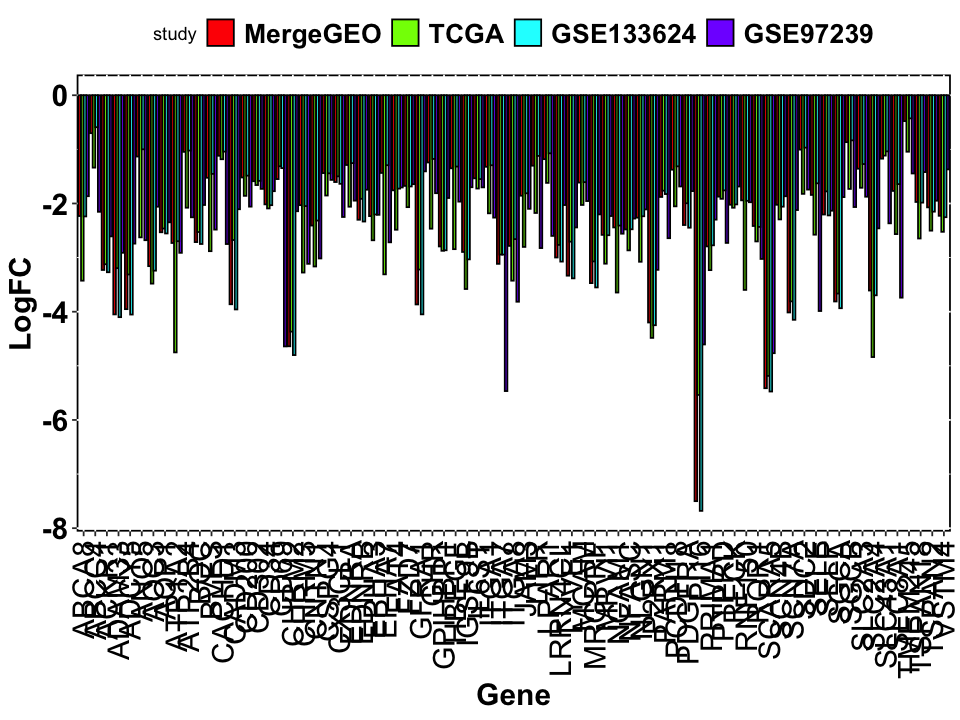

In [ ]:
df = data.frame()
for (i in names(mag75_l[1:4])) {
    print(i)
    df.tmp =  as.data.frame(mag75_l[i])
    df.tmp$study = i
    colnames(df.tmp) = c('GeneID','ProteinID','Mean_CPM_T','Mean_CPM_N','log2FoldChange','padj', 'study')
    df = rbind(df, df.tmp)
}

#df$study <- factor(x = df$study, levels = c("MergeGEO", 'TCGA', "GSE97239", "GSE133624", "MIBCvsCTL","NMIBCvsCTL" ))
df$study <- factor(x = df$study, levels = c("MergeGEO", 'TCGA', "GSE133624","GSE97239"))

mag_plot <- ggplot(df, aes(x = GeneID, y = log2FoldChange, fill = study)) +
geom_bar(stat="identity", color = 'black', position=position_dodge()) + 
theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
      axis.text.x = element_text(angle = 90, color = "black", size=18, vjust = .5, hjust =1), 
      axis.title.x = element_text(face = "bold", color = "black", size = 18),
      axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=18),
      axis.title.y = element_text(face = "bold", color = "black", size = 18),
      legend.text = element_text(face = "bold", color = "black", size = 16),
      legend.position="top",
      panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
labs(x = "Gene", y = "LogFC") + 
scale_fill_manual(values = rainbow(4))

mag_plot
pdf(paste('magic75_logFC.pdf',sep=''),width=16, height=4)
plot(mag_plot)
dev.off()

# Meta analysis

In [ ]:
library(metaRNASeq)
library(DESeq2)
library(DESeq)
library(HTSFilter)

Loading required package: locfit

locfit 1.5-9.4 	 2020-03-24

Loading required package: lattice

    Welcome to 'DESeq'. For improved performance, usability and
    functionality, please consider migrating to 'DESeq2'.


Attaching package: ‘DESeq’


The following objects are masked from ‘package:DESeq2’:

    estimateSizeFactorsForMatrix, getVarianceStabilizedData,
    varianceStabilizingTransformation




In [ ]:
gene_exp_GSE133624 = row.names(dds1)

In [ ]:
venn(list(Stay=gene_exp_GSE133624, 
          S3vs3 = gene_exp_GSE97239, 
          TCGA= gene_exp_TCGA))

In [ ]:
metadata = metadata_ArchS4
count = fCountsData

Series = 'GSE133624'

metadata_s = metadata[metadata$series == Series,]
count_s = count[,metadata_s$samples]
dds1 <- DESeqDataSetFromMatrix(countData = count_s,
                               colData = metadata_s,
                               design = as.formula("~condition"))

min.sample = as.numeric(table(metadata_s$condition)[1])
print(min.sample)
keep <- rowSums(cpm(counts(dds1)) >= 1) >= min.sample
print(table(keep))
dds1 <- dds1[keep,]

gene_exp_GSE133624 = row.names(dds1)

res1 <- results(DESeq(dds1))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 29
keep
FALSE  TRUE 
19285 15953 


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 559 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [ ]:
Series = 'GSE97239'
metadata_s = metadata[metadata$series == Series,]
count_s = count[,metadata_s$samples]
dds2 <- DESeqDataSetFromMatrix(countData = count_s,
                               colData = metadata_s,
                               design = as.formula("~condition"))

min.sample = as.numeric(table(metadata_s$condition)[1])
print(min.sample)
keep <- rowSums(cpm(counts(dds2)) >= 1) >= min.sample
print(table(keep))
dds2 <- dds2[keep,]

gene_exp_GSE97239 = row.names(dds2)

res2 <- results(DESeq(dds2))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 3
keep
FALSE  TRUE 
15058 20180 


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:
TCGAcount = read.table('../BLCA_TCGA_expression2.tsv')
metadata_TCGA = read.table('../BLCA_TCGA_metadata.tsv', sep = '\t')

In [ ]:
#TCGA

metadata_TCGA_clean = metadata_TCGA[,c('barcode','shortLetterCode')]
colnames(metadata_TCGA_clean) = c('barcode','condition')
metadata_TCGA_clean$condition = substring(metadata_TCGA_clean$condition,1,1)

dds3 <- DESeqDataSetFromMatrix(countData = TCGAcount,
                               colData = metadata_TCGA_clean,
                               design = as.formula("~condition"))

min.sample = as.numeric(table(metadata_TCGA_clean$condition)[1])
print(min.sample)
keep <- rowSums(cpm(counts(dds3)) >= 1) >= min.sample
print(table(keep))
dds3 <- dds3[keep,]

gene_exp_TCGA= row.names(dds3)
res3 <- results(DESeq(dds3))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 19
keep
FALSE  TRUE 
35782 20711 


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2175 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [ ]:
common_genes = Reduce(intersect, list(Stay=gene_exp_GSE133624, 
          S3vs3 = gene_exp_GSE97239, 
          TCGA= gene_exp_TCGA) )

res1 = res1[common_genes,]
res2 = res2[common_genes,]
res3 = res3[common_genes,]

In [ ]:
length(common_genes)

[1] 14214

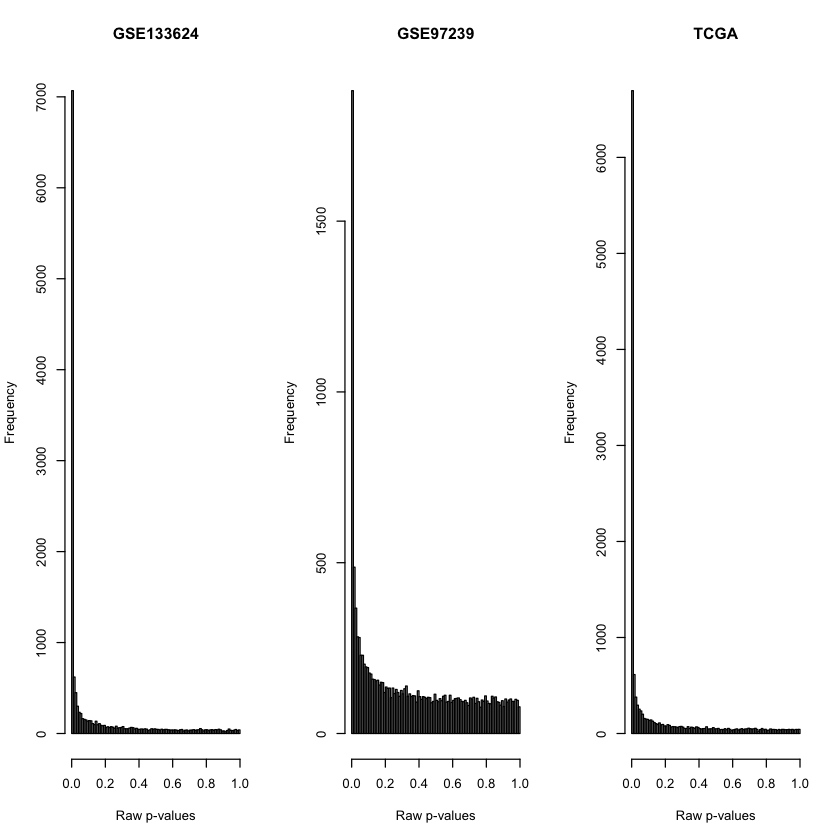

In [ ]:
#list pvalue
rawpval <- list(pval1=res1[["pvalue"]],
                pval2=res2[["pvalue"]], 
                pval3=res3[["pvalue"]])
#list FoldChange (log2)
FC <- list("FC1"=res1[["log2FoldChange"]],"FC2"=res2[["log2FoldChange"]], "FC3"=res3[["log2FoldChange"]])
#list padj
adjpval <- list("adjpval1"=res1[["padj"]],"adjpval2"=res2[["padj"]],"adjpval3"=res3[["padj"]])
# list "is DE?""
DE <- mapply(adjpval, FUN=function(x) ifelse(x <= 0.05, 1, 0))
colnames(DE)=c("DE_GSE133624","DE_GSE97239","DE_TCGA")

# plot hist             
par(mfrow = c(1,3))
hist(rawpval[[1]], breaks=100, col="grey", main="GSE133624", xlab="Raw p-values")
hist(rawpval[[2]], breaks=100, col="grey", main="GSE97239", xlab="Raw p-values")
hist(rawpval[[3]], breaks=100, col="grey", main="TCGA", xlab="Raw p-values")

In [ ]:
row.names(DE) <- row.names(res1)

### Filtering low expressed genes - padj = 1 
### NOT RUN
metadata = metadata_ArchS4
count = fCountsData

Series = 'GSE133624'
metadata_s = metadata[metadata$series == Series,]
count_s = count[,metadata_s$samples]


resDESeq1study <- function(studyname, metadata, count, cond1totest="T",
                           cond2totest="N", fitType = "parametric") {
    
    studyconds <- metadata[metadata$series == studyname,]
    study <- count[,studyconds$samples]
    colnames(study) <- paste(studyconds$sample,studyconds$condition, sep='.')
    cds <- newCountDataSet(study, studyconds$condition)
    cds <- estimateSizeFactors(cds)
    cds <- estimateDispersions(cds, method="pooled", fitType=fitType)
    ## Filter using Jaccard index for each study
    filter <- HTSFilter(cds, plot=FALSE)
    cds.filter <- filter$filteredData
    on.index <- which(filter$on == 1)
    cat("# genes passing filter", studyname, ":", dim(cds.filter)[1], "\n")
    nbT <- nbinomTest(cds.filter, cond1totest, cond2totest)
    res <- as.data.frame(matrix(NA, nrow = nrow(cds), ncol=ncol(nbT)))
    colnames(res) <- colnames(nbT)
    res[on.index,] <- nbT
    res}

studies <- c("GSE97239", "GSE133624")
resDESeq <- lapply(studies,
                   FUN=function(x) resDESeq1study(x, metadata = metadata_ArchS4, count = fCountsData))
                   
rawpval <- lapply(resDESeq, FUN=function(res) res$pval)
adjpval <- lapply(resDESeq, FUN=function(res) res$padj)
DE <- mapply(adjpval, FUN=function(x) ifelse(x <= 0.05, 1, 0))
colnames(DE)=paste("DE",studies,sep=".")
par(mfrow = c(1,2))
hist(rawpval[[1]], breaks=100, col="grey", main="Study 1", xlab="Raw p-values")
hist(rawpval[[2]], breaks=100, col="grey", main="Study 2", xlab="Raw p-values")                      

# combination 

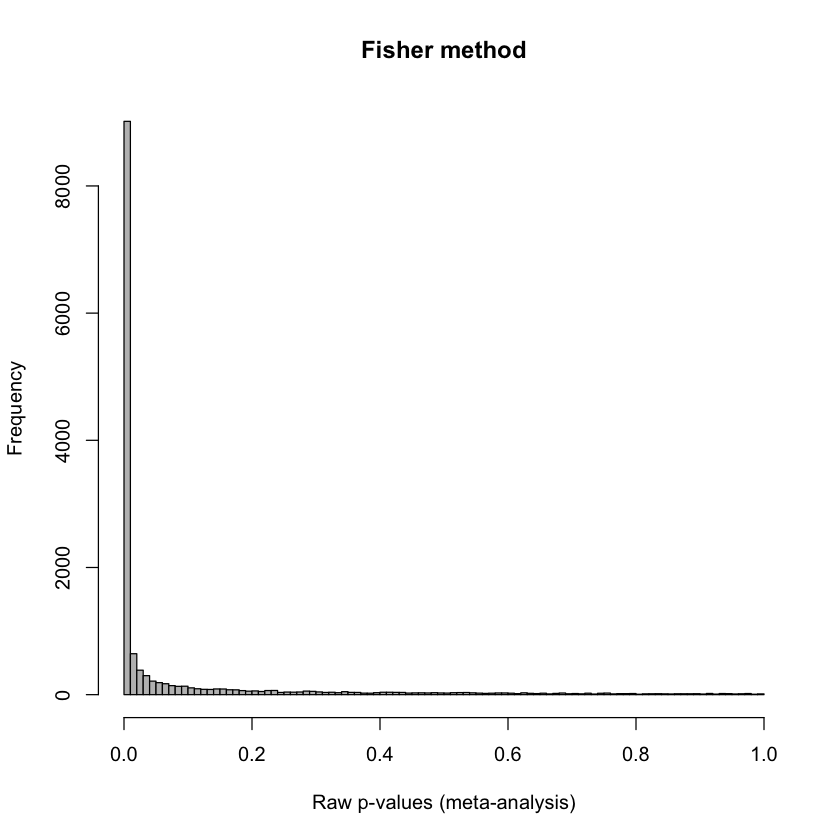

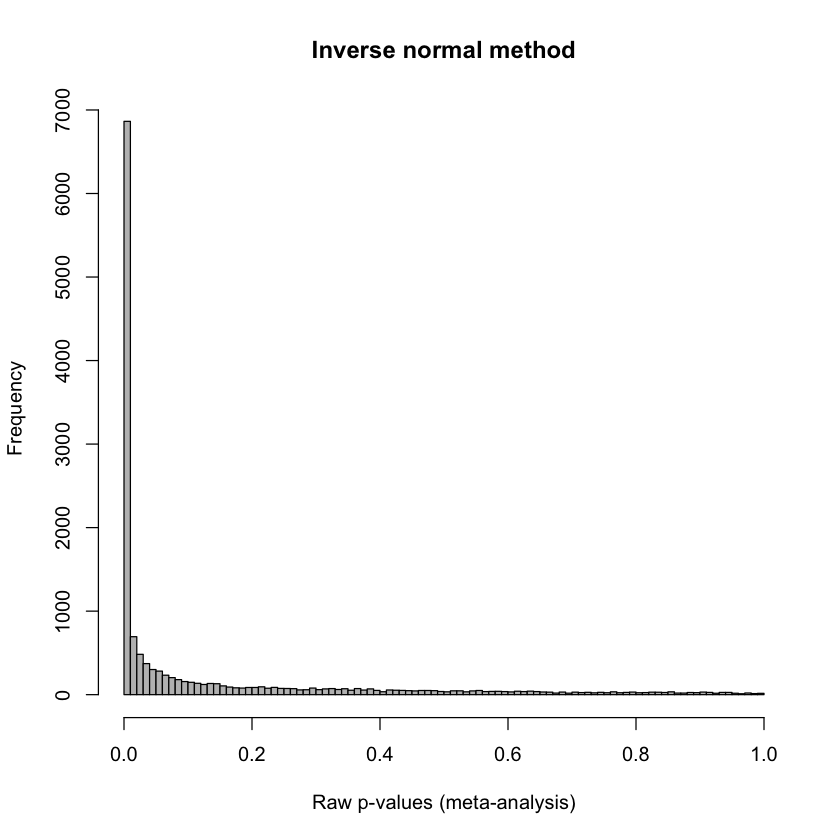

In [ ]:
fishcomb <- fishercomb(rawpval, BHth = 0.05)
hist(fishcomb$rawpval, breaks=100, col="grey", 
     main="Fisher method", 
     xlab = "Raw p-values (meta-analysis)")

#t(metadata_clean$shortLetterCode)
#nrep - min number of replica per conditions
invnormcomb <- invnorm(rawpval, 
                       nrep=c(3,29,19), 
                       #classes = list(as.character(t(metadata_GSE97239$condition)),
                    #              as.character(t(metadata_GSE133624$condition)),
                         #             as.character(t(metadata_TCGA_clean$condition))),
                       BHth = 0.05)
hist(invnormcomb$rawpval, breaks=100, col="grey", 
     main="Inverse normal method", 
     xlab = "Raw p-values (meta-analysis)")


In [ ]:
fishcomb$DEname = row.names(res1)[fishcomb$DEindices]
invnormcomb$DEname =  row.names(res1)[invnormcomb$DEindices]

In [ ]:
#'is DGE?'
DEresults <- data.frame(DE,
                        "DE.fishercomb"=ifelse(fishcomb$adjpval<=0.05,1,0),
                        "DE.invnorm"=ifelse(invnormcomb$adjpval<=0.05,1,0))
dim(DEresults)
head(DEresults)

[1] 14214     5

,DE_GSE133624,DE_GSE97239,DE_TCGA,DE.fishercomb,DE.invnorm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M,1,1,1,1,1
A2ML1,0,NA,0,0,0
A2MP1,1,NA,0,1,0
A4GALT,0,0,1,1,1
AAAS,1,0,1,1,1
AACS,1,0,1,1,1


In [ ]:
signsFC <- mapply(FC, FUN=function(x) sign(x))
sumsigns <- apply(signsFC,1,sum)
commonsgnFC <- ifelse(abs(sumsigns)==dim(signsFC)[2], sign(sumsigns),0)
unionDE <- sort(unique(c(fishcomb$DEindices,invnormcomb$DEindices)))
 
FC.selecDE <- data.frame(DEresults[unionDE,],
                         do.call(cbind,FC)[unionDE,], 
                         signFC=commonsgnFC[unionDE])
keepDE <- FC.selecDE[which(abs(FC.selecDE$signFC)==1),]
conflictDE <- FC.selecDE[which(FC.selecDE$signFC == 0),]

#checking 
dim(FC.selecDE)        
dim(keepDE)  
dim(conflictDE)    
                                   

[1] 10334     9

[1] 6498    9

[1] 3836    9

In [ ]:
head(conflictDE)
head(keepDE)

In [ ]:
fishcomb_de <- rownames(keepDE)[which(keepDE[,"DE.fishercomb"]==1)]
invnorm_de <- rownames(keepDE)[which(keepDE[,"DE.invnorm"]==1)]
indstudy_de <- list(rownames(keepDE)[which(keepDE[,"DE_GSE133624"]==1)],
                     rownames(keepDE)[which(keepDE[,"DE_GSE97239"]==1)],
                   rownames(keepDE)[which(keepDE[,"DE_TCGA"]==1)])

#names(DE)=c("DE_GSE133624","DE_GSE97239","DE_TCGA")
IDD.IRR(fishcomb_de,indstudy_de)
IDD.IRR(invnorm_de ,indstudy_de)

DE     IDD    Loss     IDR     IRR 
6451.00  160.00    6.00    2.48    0.10

DE     IDD    Loss     IDR     IRR 
5609.00  173.00  861.00    3.08   13.67

In [ ]:
Ven = list(GSE133624 = rownames(keepDE)[which(keepDE[,"DE_GSE133624"]==1)],
           GSE97239  = rownames(keepDE)[which(keepDE[,"DE_GSE97239"]==1)],
           TCGA      = rownames(keepDE)[which(keepDE[,"DE_TCGA"]==1)],
           fisher    = rownames(keepDE)[which(keepDE[,"DE.fishercomb"]==1)],
           invnorm   = rownames(keepDE)[which(keepDE[,"DE.invnorm"]==1)])

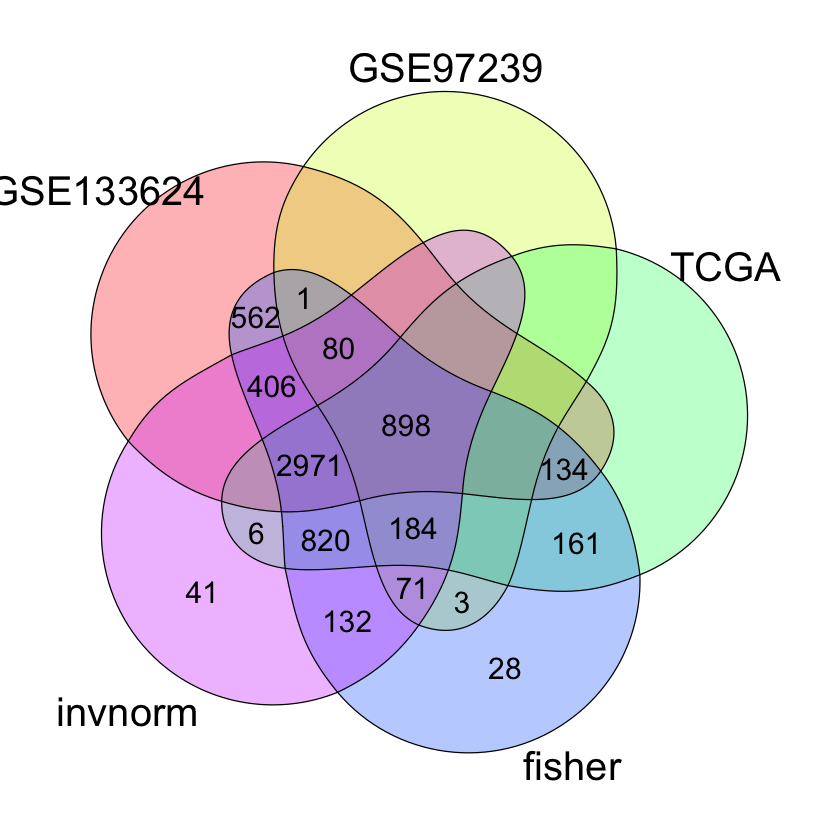

In [ ]:
venn(Ven,
     simplify=TRUE, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(5), 
     ilcs = 1.5, sncs = 2)

In [ ]:
shared_genes = Reduce(intersect,Ven)
shared_genes_table = keepDE[shared_genes,]
metaUP = row.names(shared_genes_table[shared_genes_table$signFC==1,])
metaDW = row.names(shared_genes_table[shared_genes_table$signFC==-1,])

In [ ]:
dir = 'metaRNAseq/'
dir.create(dir)
i = 'meta'
modulation = c('UP')#,'DW')
    fdr = list(UP = metaUP, DW = metaDW)
    for (m in modulation) { 
        proteins = ST[ST$UniProt.gene %in% fdr[[m]],]
        proteins = proteins[!is.na(proteins$Surfaceome.Label),]
        print(table(proteins$Surfaceome.Label))
        surface.proteins = proteins[proteins$Surfaceome.Label=='surface',]  
        }

In [ ]:
Meta_protein = surface.proteins$UniProt.name
Meta_gene = surface.proteins$UniProt.gene
shared_genes_table[Meta_gene,]

In [ ]:
MetaAnalysis = list(GSE133624 = keepDE[which(keepDE[,"DE_GSE133624"]==1),],
                    GSE97239  = keepDE[which(keepDE[,"DE_GSE97239"]==1),],
                    TCGA      = keepDE[which(keepDE[,"DE_TCGA"]==1),],
                    fisher    = keepDE[which(keepDE[,"DE.fishercomb"]==1),],
                    invnorm   = keepDE[which(keepDE[,"DE.invnorm"]==1),])

In [ ]:
surface.proteins

,UniProt.name,UniProt.accession,UniProt.description,UniProt.gene,Surfaceome.Label,Surfaceome.Label.Source,Comment,length,TM.domains,signalpeptide,⋯,CSPA.id,UniProt.subcellular,UniProt.keywords,UniProt.uniref,COMPARTMENTS.link,COMPARTMENTS.benchmark.pos,COMPARTMENTS.benchmark.neg,HPA.antibody,DrugBank.approved.drug.IDs,GeneID
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TSN11_HUMAN,TSN11_HUMAN,A1L157,Tetraspanin-11,TSPAN11,surface,machine learning,NA,253,4,0,⋯,NA,Membrane (Multi-pass membrane protein),Complete proteome;Glycoprotein;Membrane;Polymorphism;Reference proteome;Transmembrane;Transmembrane helix,UniRef100_A1L157;UniRef90_A1L157;UniRef50_A1L157,link,NA,Cytoskeleton;Cytosol;Endoplasmic Reticulum;Endosome;Extracellular space;Golgi apparatus;Lysosome;Mitochondrion;Nucleus;Peroxisome,no,NA,441631
TMM8B_HUMAN,TMM8B_HUMAN,A6NDV4,Transmembrane protein 8B,TMEM8B,surface,machine learning,NA,472,7,0,⋯,NA,Cell membrane (Multi-pass membrane protein);Cytoplasm;Endoplasmic reticulum;Mitochondrion;Nucleus,Alternative splicing;Cell adhesion;Cell membrane;Complete proteome;Cytoplasm;Disulfide bond;EGF-like domain;Endoplasmic reticulum;Glycoprotein;Growth regulation;Membrane;Mitochondrion;Nucleus;Reference proteome;Transmembrane;Transmembrane helix,UniRef100_A6NDV4;UniRef90_A6NDV4;UniRef50_A6NDV4,link,Endoplasmic Reticulum;Mitochondrion;Plasma membrane,Cytoskeleton;Extracellular space,HPA052130,NA,51754
TIKI2_HUMAN,TIKI2_HUMAN,A6NFA1,Metalloprotease TIKI2,TRABD2B,surface,machine learning,NA,517,1,1,⋯,NA,Cell membrane (Single-pass type I membrane protein),Cell membrane;Complete proteome;Glycoprotein;Hydrolase;Membrane;Metal-binding;Metalloprotease;Protease;Reference proteome;Signal;Transmembrane;Transmembrane helix;Wnt signaling pathway,UniRef100_A6NFA1;UniRef90_A6NFA1;UniRef50_A6NFA1,link,NA,NA,HPA045817,NA,388630
TLR4_HUMAN,TLR4_HUMAN,O00206,Toll-like receptor 4,TLR4,surface,pos. trainingset,NA,839,1,1,⋯,O00206,Cell membrane (Single-pass type I membrane protein),3D-structure;Age-related macular degeneration;Alternative splicing;Cell membrane;Complete proteome;Direct protein sequencing;Disulfide bond;Glycoprotein;Immunity;Inflammatory response;Innate immunity;Leucine-rich repeat;Membrane;Polymorphism;Receptor;Reference proteome;Repeat;Signal;Transmembrane;Transmembrane helix,UniRef100_O00206;UniRef90_O00206;UniRef50_O00206,link,Plasma membrane,Cytoskeleton;Cytosol;Endoplasmic Reticulum;Endosome;Extracellular space;Golgi apparatus;Lysosome;Mitochondrion;Nucleus;Peroxisome,CAB004025;HPA049174,DB01183,7099
GFRA2_HUMAN,GFRA2_HUMAN,O00451,GDNF family receptor alpha-2,GFRA2,surface,GPI (UniProt),NA,464,0,1,⋯,O00451,"Cell membrane (Lipid-anchor, GPI-anchor)",Alternative splicing;Cell membrane;Complete proteome;Glycoprotein;GPI-anchor;Lipoprotein;Membrane;Polymorphism;Receptor;Reference proteome;Signal,UniRef100_O00451;UniRef90_O00451;UniRef50_O00451,link,NA,NA,HPA024704;CAB032791,NA,2675
NRG2_HUMAN,NRG2_HUMAN,O14511,"Pro-neuregulin-2, membrane-bound isoform",NRG2,surface,machine learning,NA,850,1,0,⋯,NA,Secreted;Cell membrane (Single-pass type I membrane protein),Alternative splicing;Cell membrane;Complete proteome;Disulfide bond;EGF-like domain;Glycoprotein;Growth factor;Immunoglobulin domain;Membrane;Reference proteome;Secreted;Transmembrane;Transmembrane helix,UniRef100_O14511;UniRef90_O14511;UniRef50_O14511,link,NA,NA,HPA038935;HPA047973,NA,9542
TSN4_HUMAN,TSN4_HUMAN,O14817,Tetraspanin-4,TSPAN4,surface,machine learning,NA,238,4,0,⋯,O14817,Membrane (Multi-pass membrane protein),Complete proteome;Glycoprotein;Membrane;Polymorphism;Reference proteome;Transmembrane;Transmembrane helix,UniRef100_O14817;UniRef90_O14817;UniRef50_O14817,link,NA,NA,HPA016435,NA,7106
LRAD4_HUMAN,LRAD4_HUMAN,O15165,Low-density lipoprotein receptor class A domain-containing protein 4,LDLRAD4,surface,machine learning,NA,306,1,0,⋯,NA,Early endosome membrane (Single-pass membrane protein),Alter

In [ ]:
dirMeta = 'metaRNAseq/'
dir.create(dirMeta)
Surface_META_UP = list()
Surface_META_DW = list()
Surface_META_UP_g = list()
Surface_META_DW_g = list()
for (names in names(MetaAnalysis)) {
    md = MetaAnalysis[[names]]
    metaUP = row.names(md[md$signFC==1,])
    metaDW = row.names(md[md$signFC==-1,])
    i = names
    modulation = c('UP','DW')
    fdr = list(UP = metaUP, DW = metaDW)
    for (m in modulation) { 
        proteins = ST[ST$UniProt.gene %in% fdr[[m]],]
        proteins = proteins[!is.na(proteins$Surfaceome.Label),]
        print(table(proteins$Surfaceome.Label))
        surface.proteins = proteins[proteins$Surfaceome.Label=='surface',]
        surface.genes = surface.proteins$UniProt.gene
        surface.proteinsID = surface.proteins$UniProt.name
        if (m == 'UP') {
            Surface_META_UP[[names]] = surface.proteinsID
            Surface_META_UP_g[[names]] = surface.genes
        }
        else {
            Surface_META_DW[[names]] = surface.proteinsID
            Surface_META_DW_g[[names]] = surface.genes
        }
        surfaceome_DGEresults = as.data.frame(MetaAnalysis[[names]][surface.genes,])
        surfaceome_DGEresults$GeneID = row.names(surfaceome_DGEresults)
        surfaceome_DGEresults$ProteinID = surface.proteins$UniProt.name
        write.xlsx(surfaceome_DGEresults[,c('GeneID','ProteinID',
                                           'DE_GSE133624','DE_GSE97239','DE_TCGA',
                                            'DE.fishercomb','DE.invnorm','FC1','FC2','FC3','signFC')],
               paste(dirMeta,'DGE_BladderSurfaceome_',i,'_',m,'_meta.xlsx',sep=''), 
               asTable = T, row.names= F)  
        }
    }

Warning message in dir.create(dirMeta):
“'metaRNAseq' already exists”



nonsurface    surface 
       352        207 

nonsurface    surface 
       190        410 

nonsurface    surface 
       126         74 

nonsurface    surface 
        45         84 

nonsurface    surface 
       389        232 

nonsurface    surface 
       206        330 

nonsurface    surface 
       489        304 

nonsurface    surface 
       238        442 

nonsurface    surface 
       432        275 

nonsurface    surface 
       216        365 


In [ ]:
colnames(surfaceome_DGEresults)

[1] "DE_GSE133624"  "DE_GSE97239"   "DE_TCGA"       "DE.fishercomb"
 [5] "DE.invnorm"    "FC1"           "FC2"           "FC3"          
 [9] "signFC"        "GeneID"        "ProteinID"

pdf 
  2

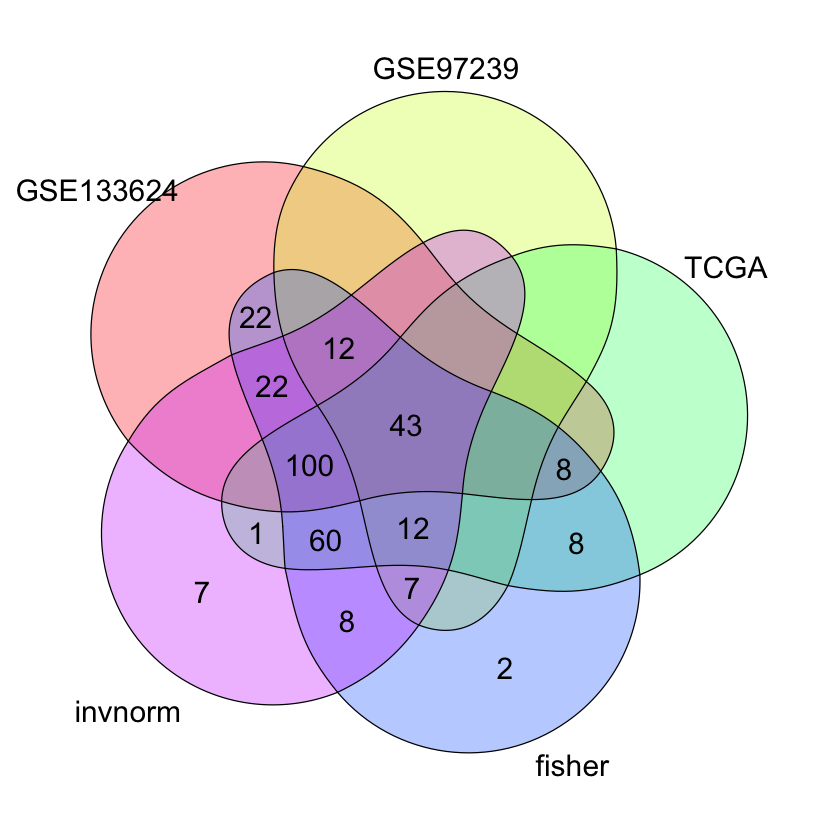

In [ ]:


pdf(paste(dirMeta,'Venn_intersection_UP_Meta.pdf',sep=''),width=8, height=8)
venn(Surface_META_UP,
     simplify=TRUE, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(5), 
     ilcs = 1.5, sncs = 1.5)
dev.off()

venn(Surface_META_UP_g,
     simplify=TRUE, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(5), 
     ilcs = 1.5, sncs = 1.5)

pdf 
  2

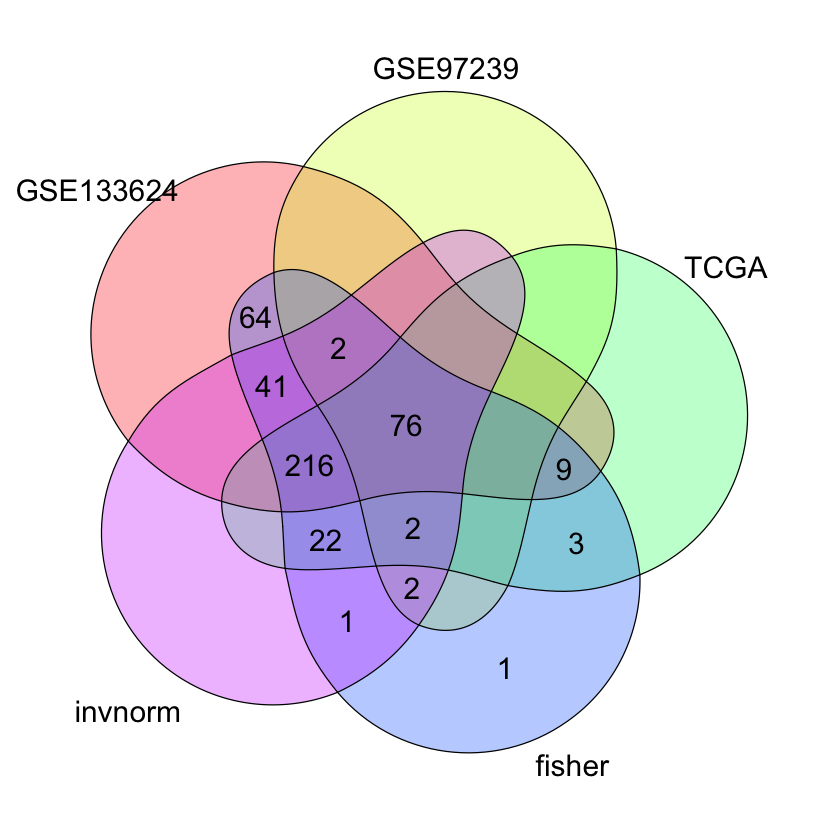

In [ ]:
pdf(paste(dirMeta,'Venn_intersection_DW_Meta.pdf',sep=''),width=8, height=8)
venn(Surface_META_DW,
     simplify=TRUE, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(5), 
     ilcs = 1.5, sncs = 1.5)
dev.off()
venn(Surface_META_DW_g,
     simplify=TRUE, opacity = 0.3, box = FALSE, ilab=TRUE, 
     zcolor = rainbow(5), 
     ilcs = 1.5, sncs = 1.5)

In [ ]:
mag77_meta = Reduce(intersect,Surface_META_DW)

setdiff(mag75, mag77_meta)
setdiff(mag77_meta, mag75)


[1] "FZD7_HUMAN"

[1] "NRX1B_HUMAN" "NRX1A_HUMAN" "NTNG1_HUMAN"